# Case Study-Forecasting Bus Demand in Banana Municipalities For a Week


The task is to forecast the hourly bus usage for the next week for each municipality in Banana Republic, based on the given dataset. The dataset includes two measurements per hour for each municipality, along with the timestamp, usage, and total capacity. The goal is to aggregate the two measurements per hour by taking the maximum value and model this data using a time series model.

To begin with, a simple baseline model should be implemented, followed by more complex methods to improve the accuracy. The committee will use the last two weeks of the dataset (starting from 2017-08-05 to 2017-08-19) as assessment (test) data. The code should report the error for the last two weeks. True values can be used to predict the last week of test data, and the error of the first and last week of the test should be combined separately.

It should be noted that the dataset has missing data, so a suitable missing data interpolation method should be used.

In this step, we import all the necessary libraries required for data processing, visualization, and modeling.

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [53]:
# Load the dataset
df = pd.read_csv('https://pi.works/3w8IJbV')
df.columns = ['Timestamp', 'Municipality_ID', 'Usage', 'Total_Capacity']
df.head()

Timestamp  Municipality_ID  Usage  Total_Capacity
0  2017-06-04 07:59:42                9    454            1332
1  2017-06-04 07:59:42                8    556            2947
2  2017-06-04 07:59:42                4   1090            3893
3  2017-06-04 07:59:42                0    204            2813
4  2017-06-04 07:59:42                7    718            2019

In [32]:
num_null_first = df.isnull().sum()
num_null_first

Timestamp          0
Municipality_ID    0
Usage              0
Total_Capacity     0
dtype: int64

In [34]:
# data types as result
datatypes_originally = df.dtypes
  
# Print the data types of each column
datatypes_originally

Timestamp          object
Municipality_ID     int64
Usage               int64
Total_Capacity      int64
dtype: object

In [35]:
# Convert the Timestamp column to a datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [36]:
# data types as result
datatypes_convert = df.dtypes
  
# Print the data types of each column
datatypes_convert

Timestamp          datetime64[ns]
Municipality_ID             int64
Usage                       int64
Total_Capacity              int64
dtype: object

In [37]:
hour = df['Hour'] = df['Timestamp'].dt.hour
#minute = df['minute'] = df['timestamp'].dt.minute
time = df['Time'] = df['Timestamp'].dt.date

# Convert the Timestamp column to a datetime object
df['Time'] = pd.to_datetime(df['Time'])

In [39]:
# Group the dataframe by hour and take the max usage value
df_hourly_max = df.groupby([pd.Grouper(key='Timestamp', freq='H'),'Time','Hour','Municipality_ID','Total_Capacity'], as_index=False)['Usage'].max()

# Display the resulting dataframe
df_hourly_max.head()


Time  Hour  Municipality_ID  Total_Capacity  Usage
0 2017-06-04     7                0            2813    204
1 2017-06-04     7                1             397    129
2 2017-06-04     7                2             697    273
3 2017-06-04     7                3            1930    623
4 2017-06-04     7                4            3893   1090

In [40]:
num_null = df_hourly_max.isnull().sum()
print("Number of empty values in Usage column:", num_null)

# Print the summary info of the dataframe
print(df_hourly_max.info())

# Print the average, minimum and maximum of the 'Usage' column
print("Average usage: ", df_hourly_max['Usage'].mean())
print("Minimum usage: ", df_hourly_max['Usage'].min())
print("Maximum usage: ", df_hourly_max['Usage'].max())


Number of empty values in Usage column: Time               0
Hour               0
Municipality_ID    0
Total_Capacity     0
Usage              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             6740 non-null   datetime64[ns]
 1   Hour             6740 non-null   int64         
 2   Municipality_ID  6740 non-null   int64         
 3   Total_Capacity   6740 non-null   int64         
 4   Usage            6740 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 263.4 KB
None
Average usage:  893.3216617210683
Minimum usage:  12
Maximum usage:  3508


In [41]:
start_date = pd.to_datetime('2017-08-05')
end_date = pd.to_datetime('2017-08-19')

test_data = df_hourly_max[(df_hourly_max['Time'] >= start_date) & (df_hourly_max['Time'] <= end_date)]
train_data = df_hourly_max[df_hourly_max['Time'] < start_date]
test_data = test_data.reset_index(drop=True)

In [42]:
train_data

Time  Hour  Municipality_ID  Total_Capacity  Usage
0    2017-06-04     7                0            2813    204
1    2017-06-04     7                1             397    129
2    2017-06-04     7                2             697    273
3    2017-06-04     7                3            1930    623
4    2017-06-04     7                4            3893   1090
...         ...   ...              ...             ...    ...
5315 2017-08-02    16                5             587    114
5316 2017-08-02    16                6            3113   1018
5317 2017-08-02    16                7            2019   1169
5318 2017-08-02    16                8            2947   1035
5319 2017-08-02    16                9            1332    625

[5320 rows x 5 columns]

In [43]:
test_data

Time  Hour  Municipality_ID  Total_Capacity  Usage
0    2017-08-05     8                0            2813    252
1    2017-08-05     8                1             397    158
2    2017-08-05     8                2             697    327
3    2017-08-05     8                3            1930    781
4    2017-08-05     8                4            3893   2132
...         ...   ...              ...             ...    ...
1415 2017-08-19    16                5             587    239
1416 2017-08-19    16                6            3113   1727
1417 2017-08-19    16                7            2019   1450
1418 2017-08-19    16                8            2947   1253
1419 2017-08-19    16                9            1332    879

[1420 rows x 5 columns]

In [44]:
train_data['Datetime'] = pd.to_datetime(train_data['Time'].dt.strftime('%Y-%m-%d') + ' ' + train_data['Hour'].astype(str) + ':00:00')
test_data['Datetime'] = pd.to_datetime(test_data['Time'].dt.strftime('%Y-%m-%d') + ' ' + test_data['Hour'].astype(str) + ':00:00')

C:\Users\bugra\AppData\Local\Temp\ipykernel_35244\409188261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Datetime'] = pd.to_datetime(train_data['Time'].dt.strftime('%Y-%m-%d') + ' ' + train_data['Hour'].astype(str) + ':00:00')


## Forecasting with ExponentialSmoothing algorithm

RMSE for Municipality 0: 340.9772


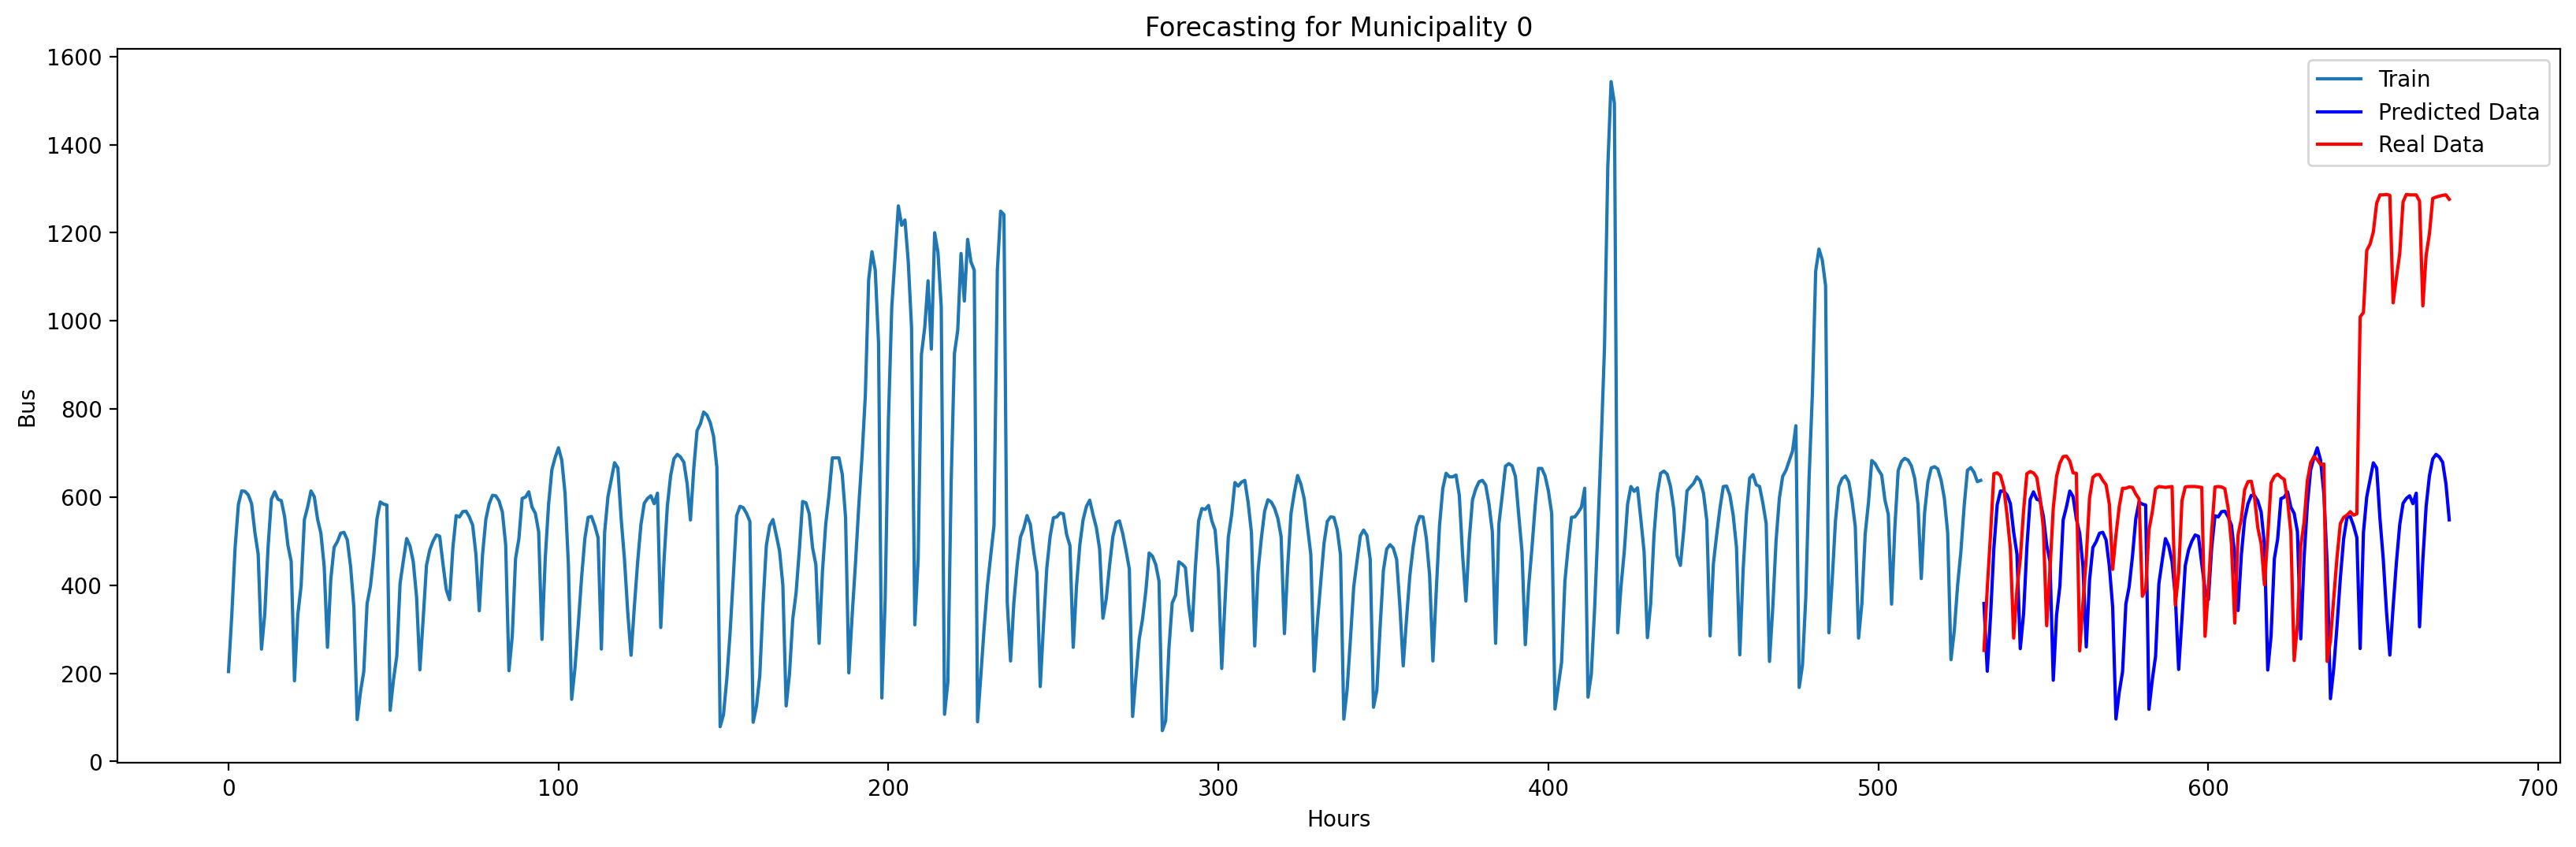

RMSE for Municipality 1: 120.5679


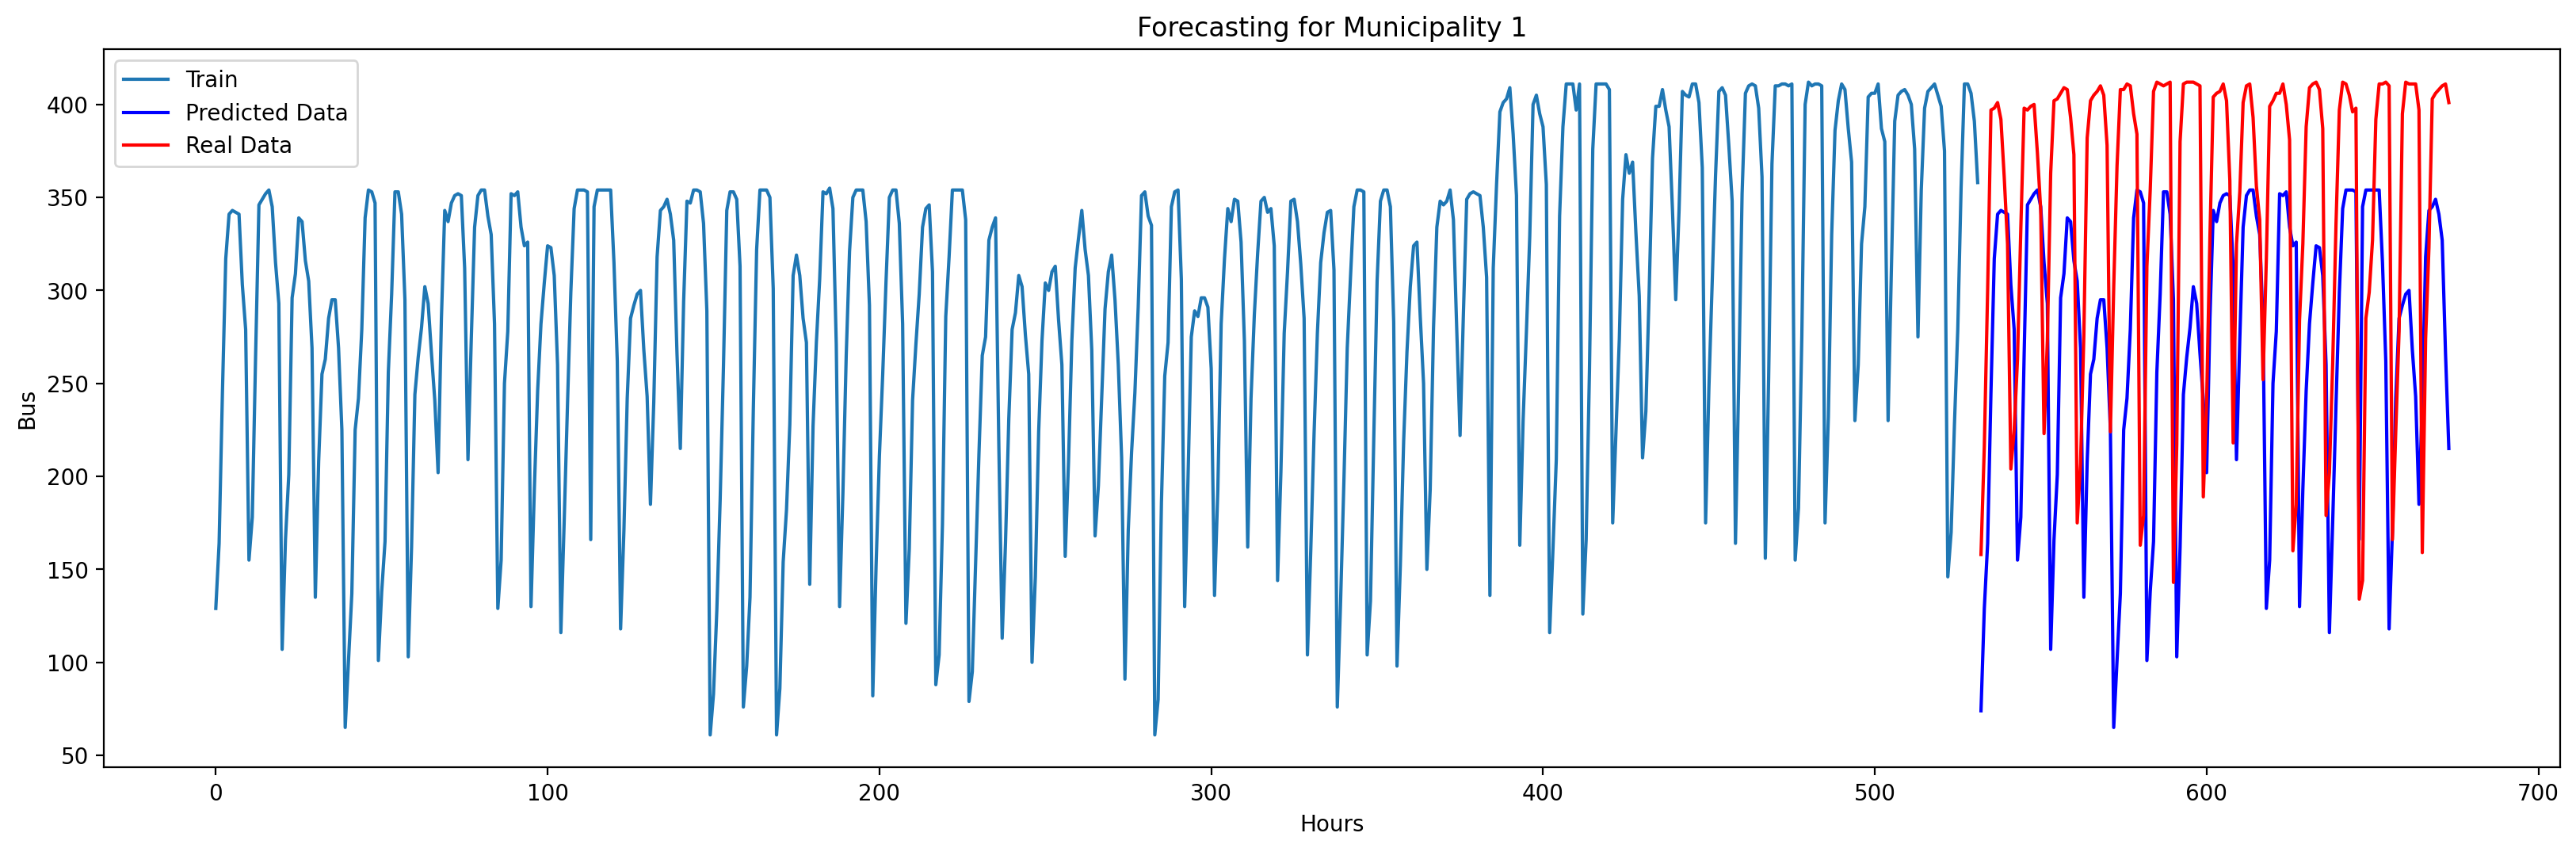

RMSE for Municipality 2: 132.9360


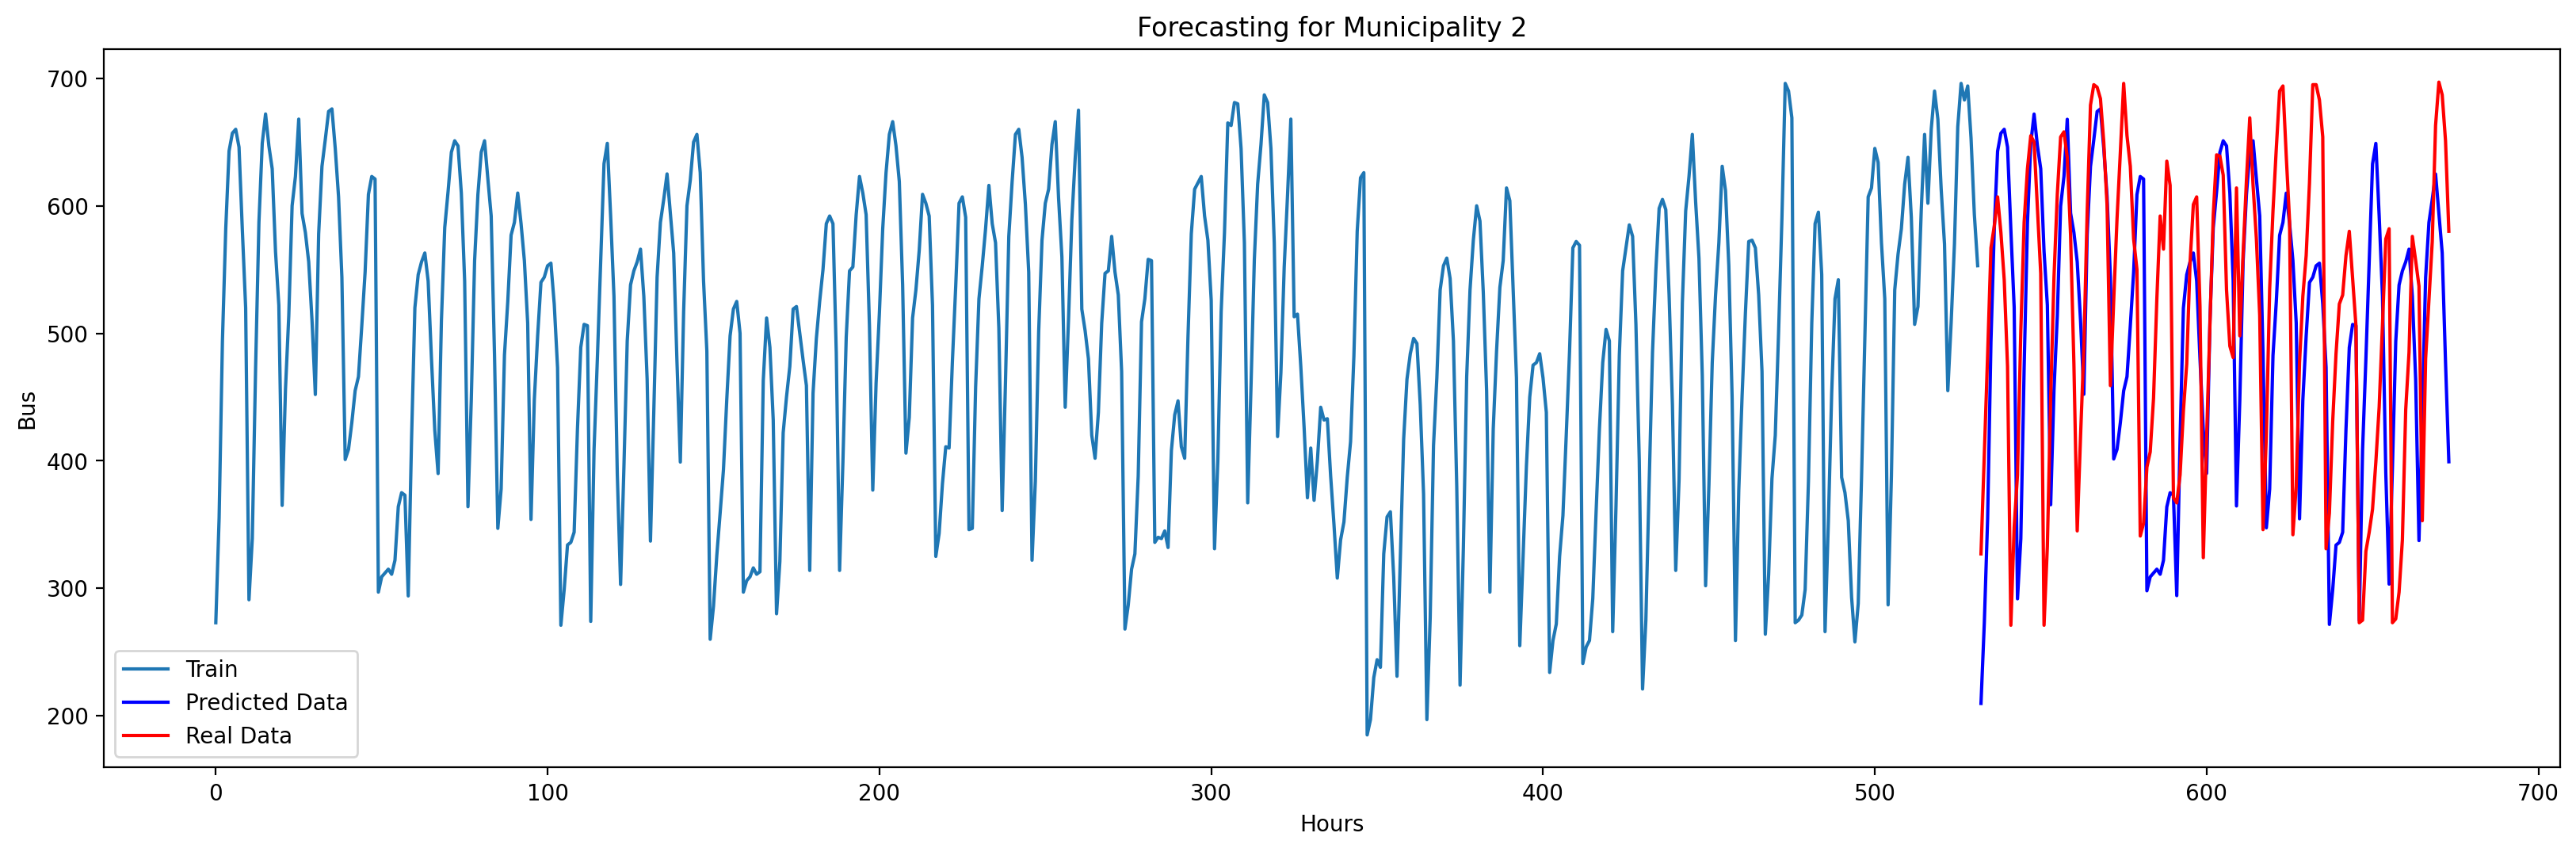

RMSE for Municipality 3: 402.2167


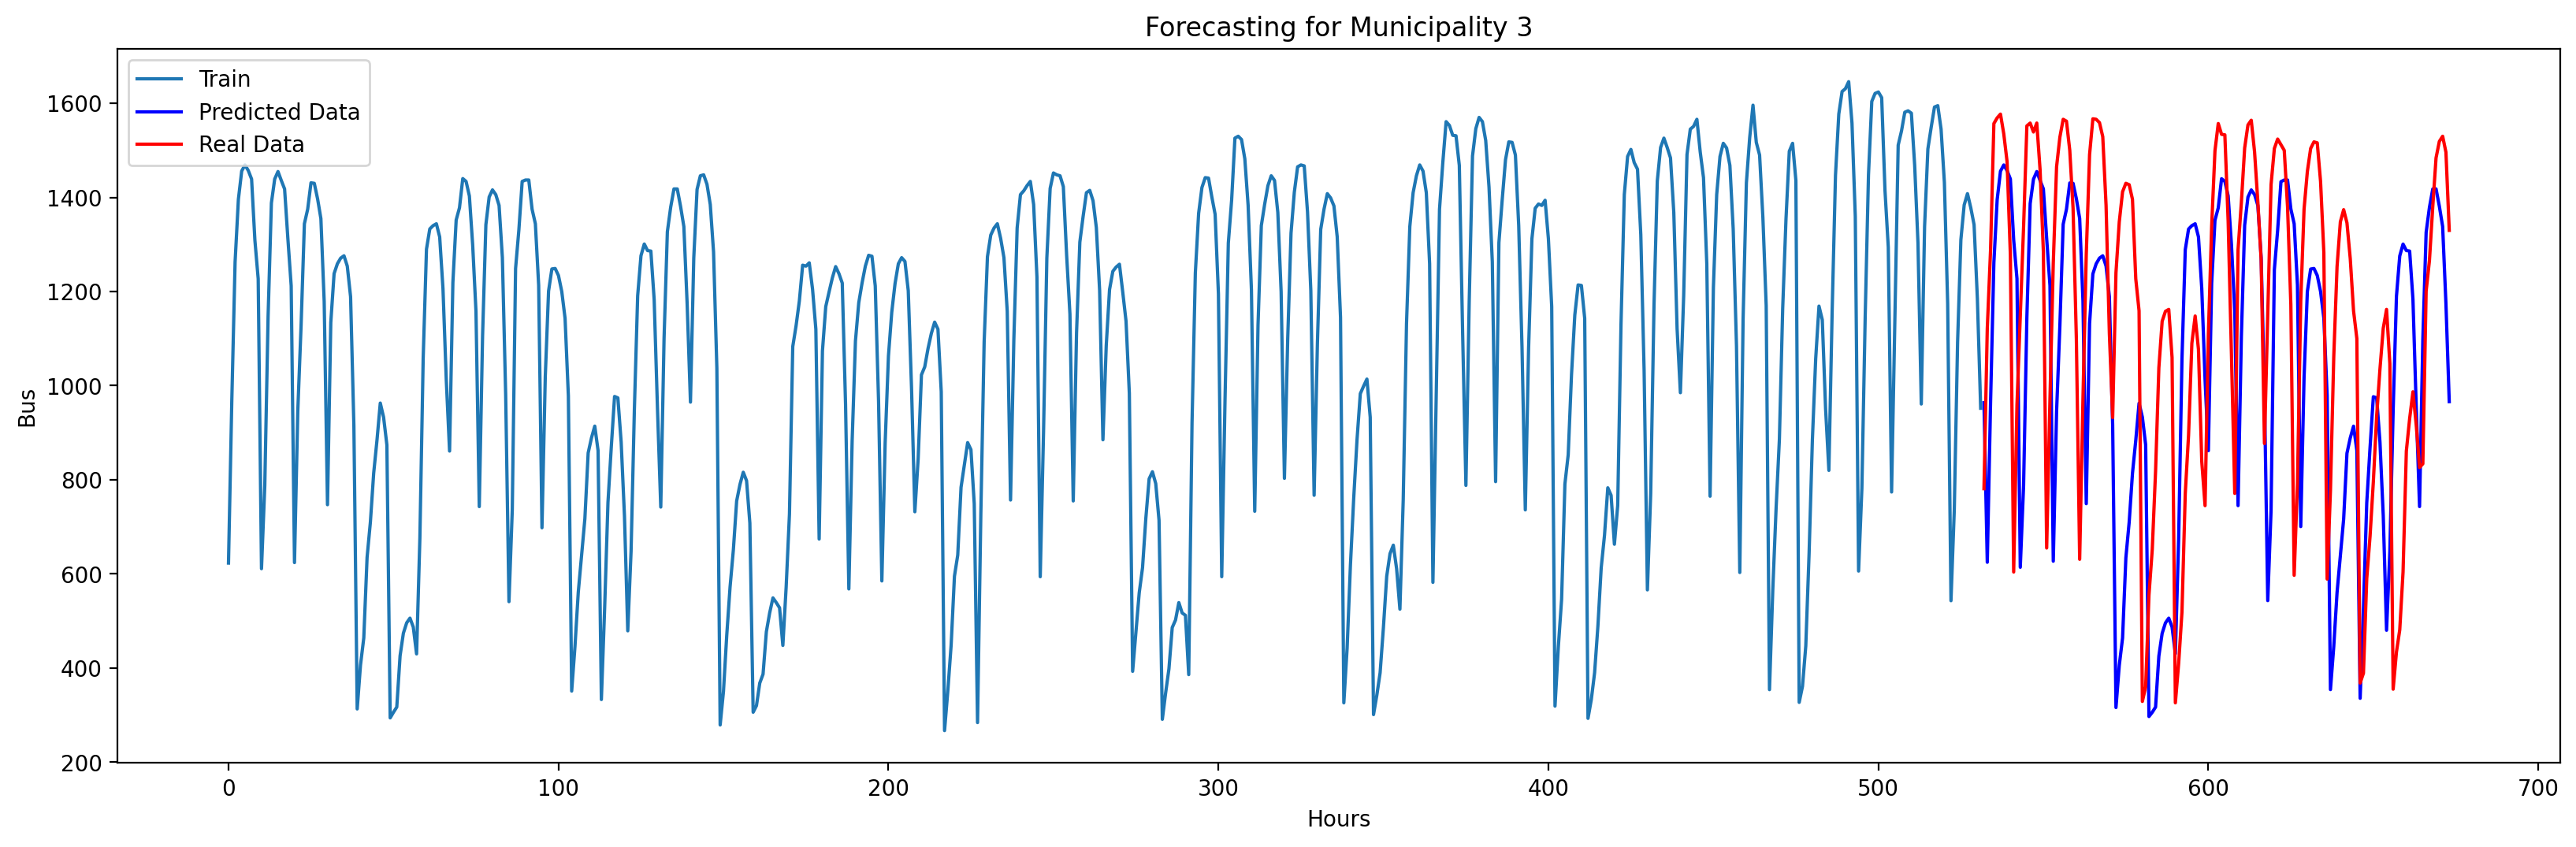

RMSE for Municipality 4: 976.2654


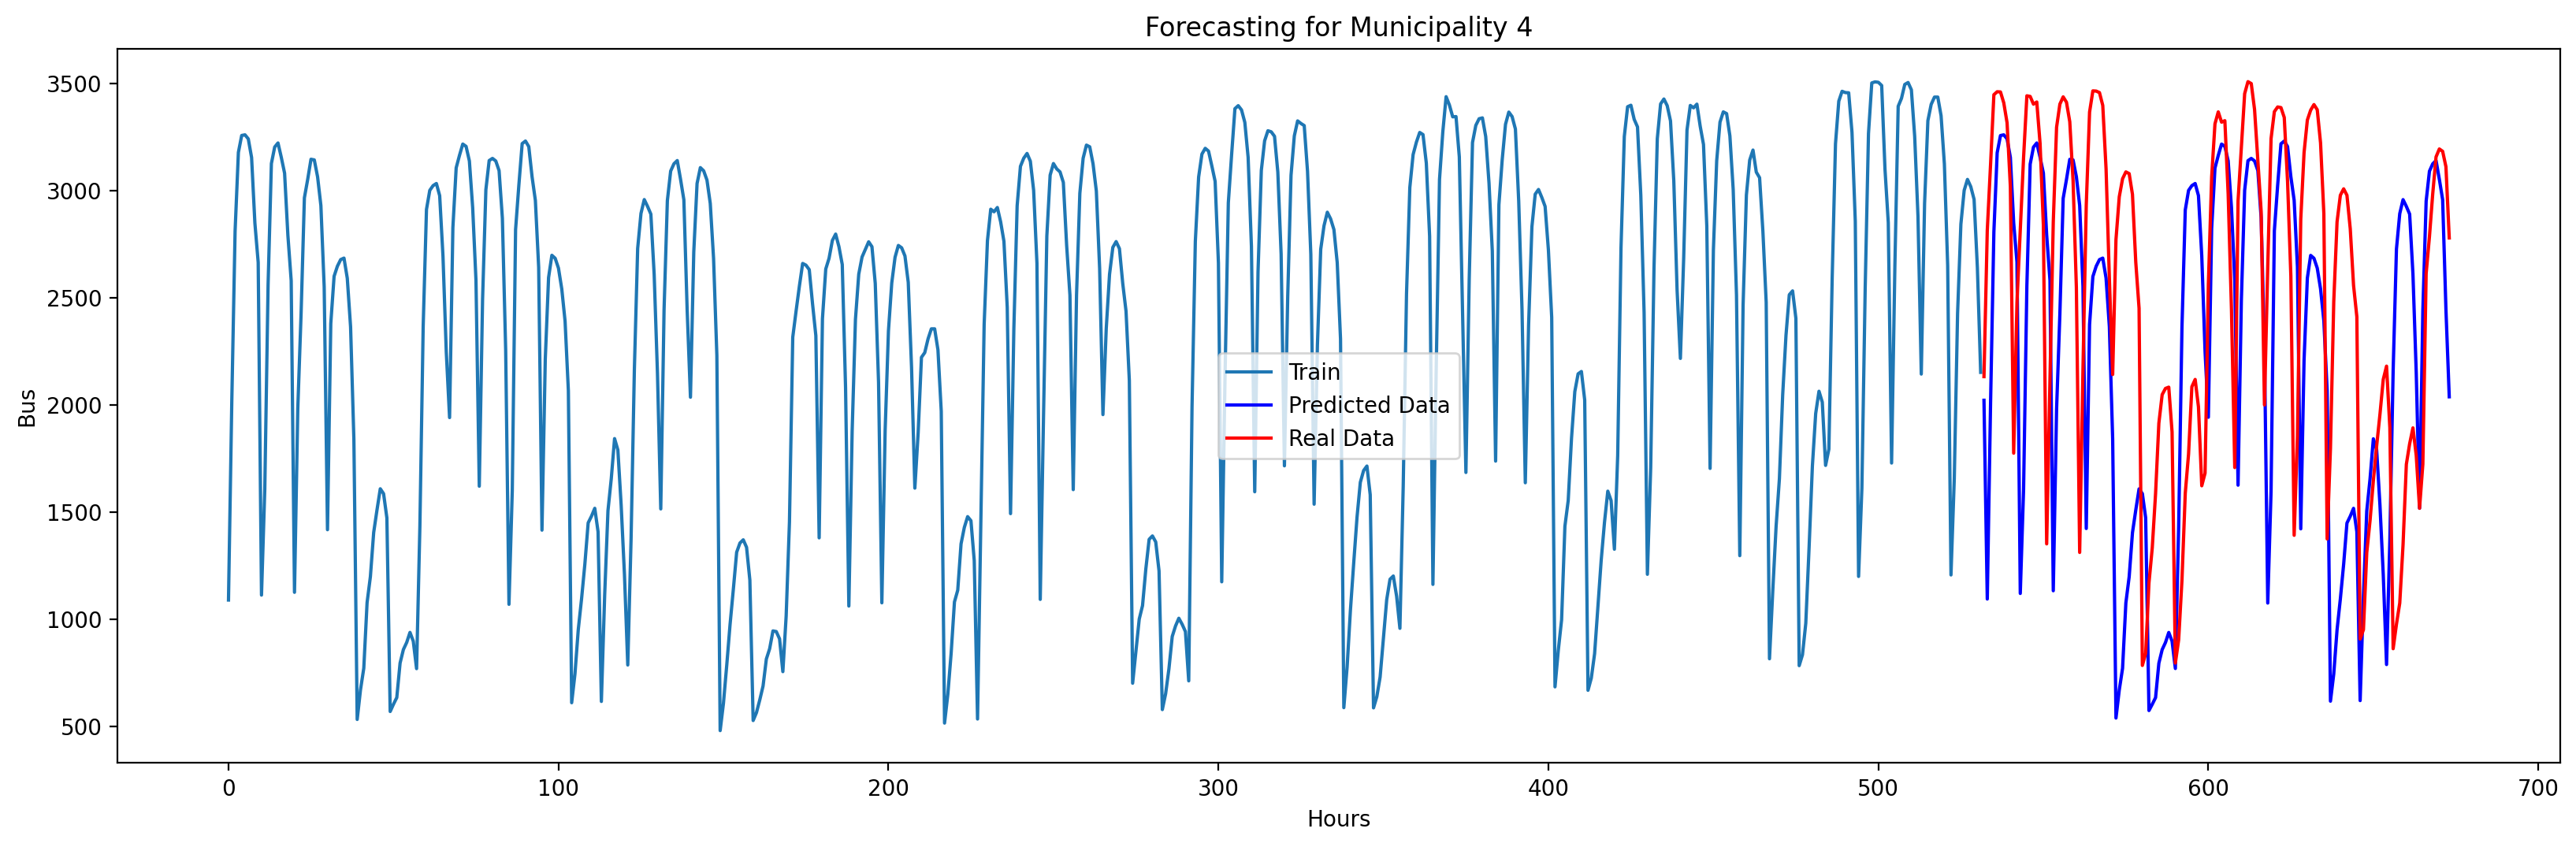

RMSE for Municipality 5: 123.4987


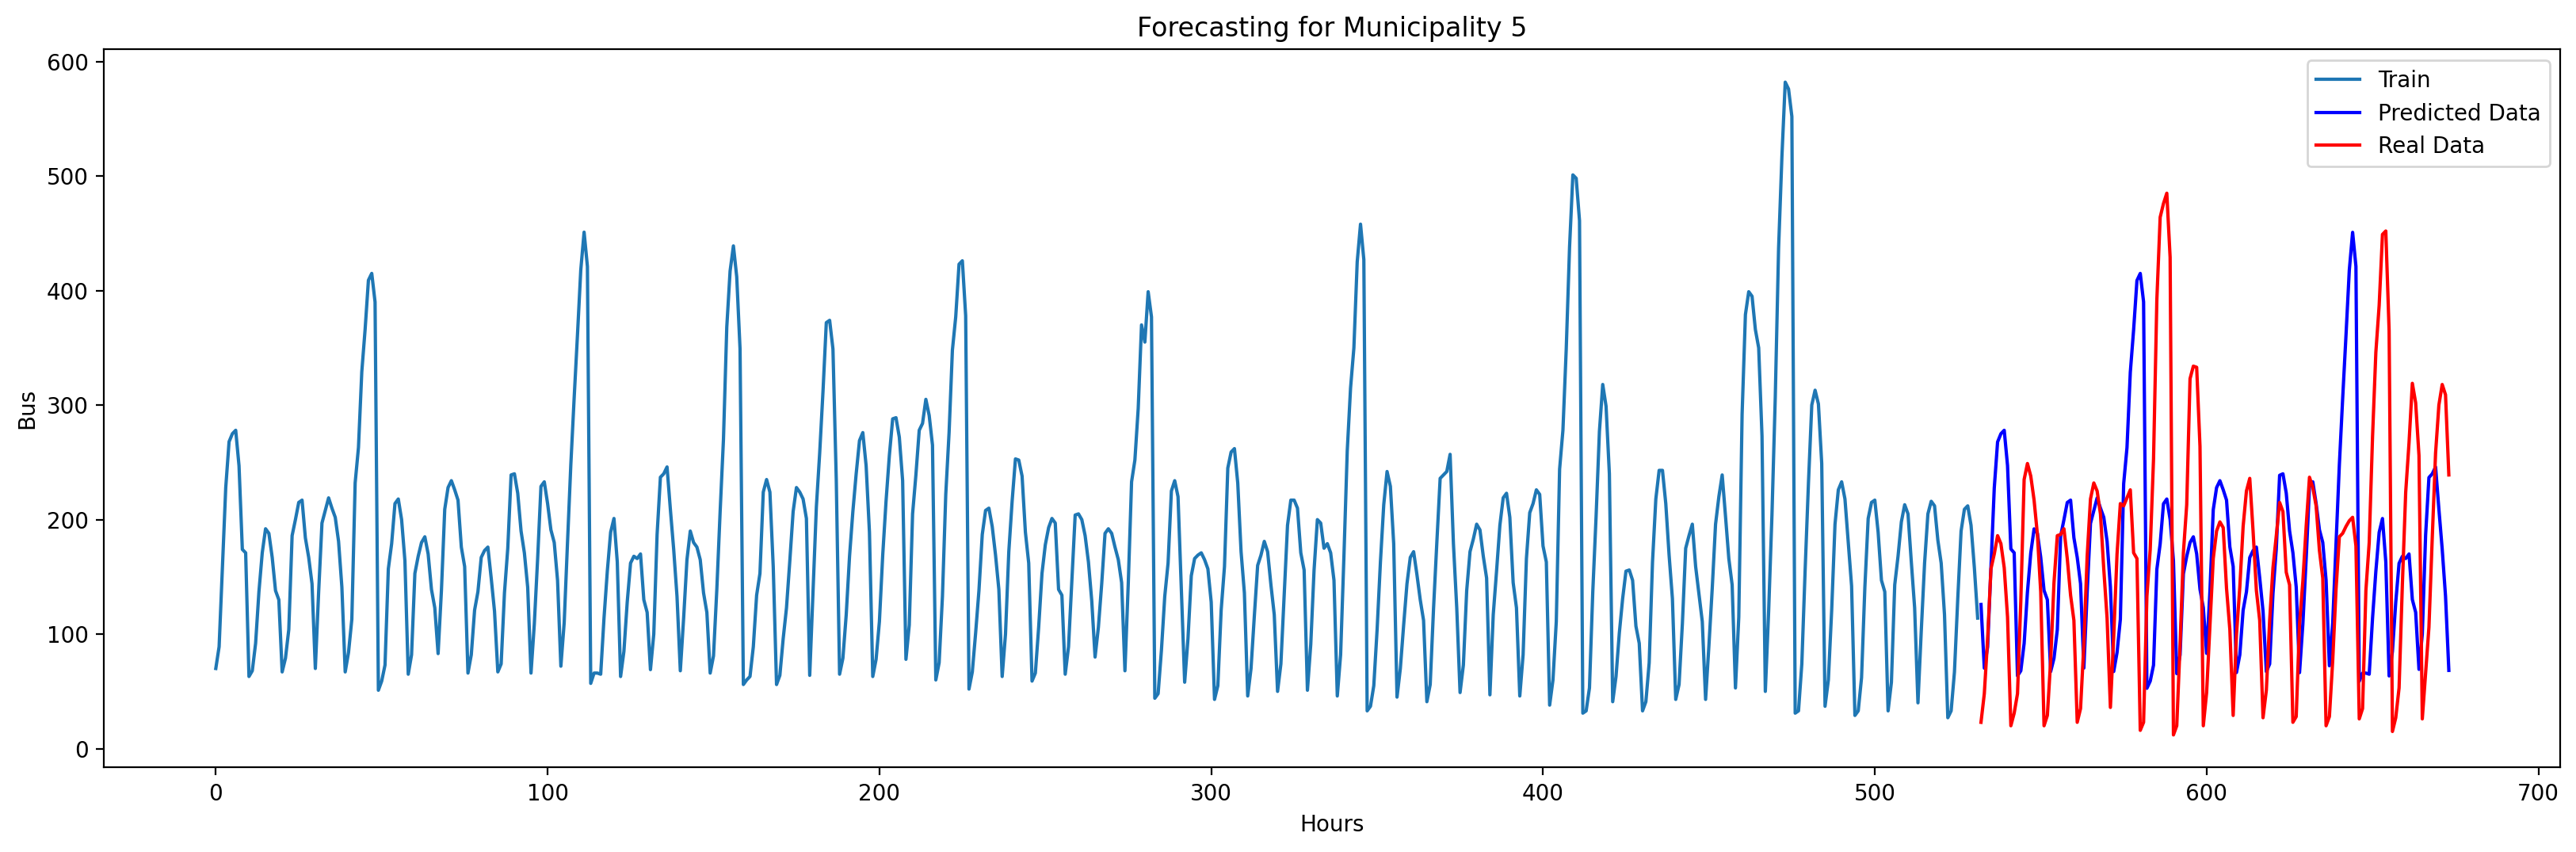

RMSE for Municipality 6: 323.8531


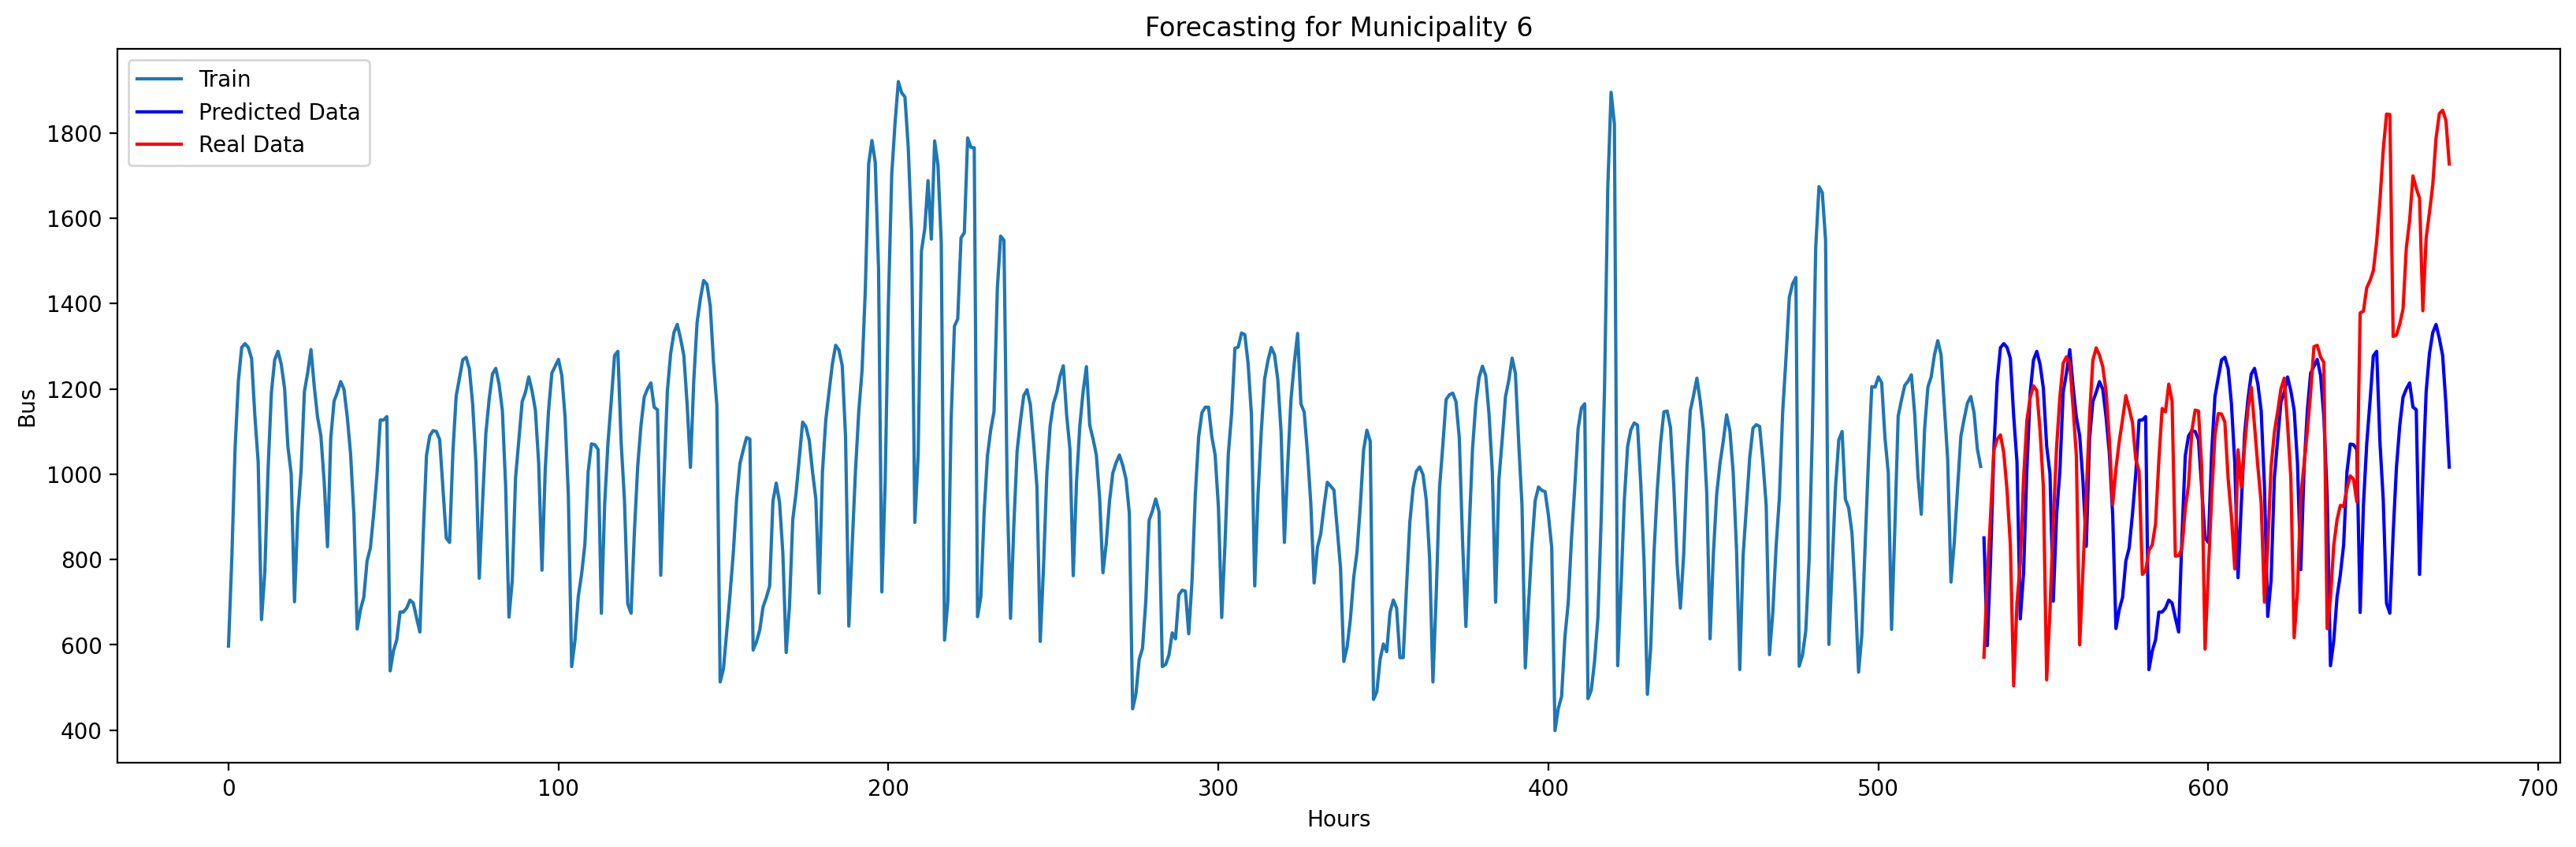

RMSE for Municipality 7: 320.4777


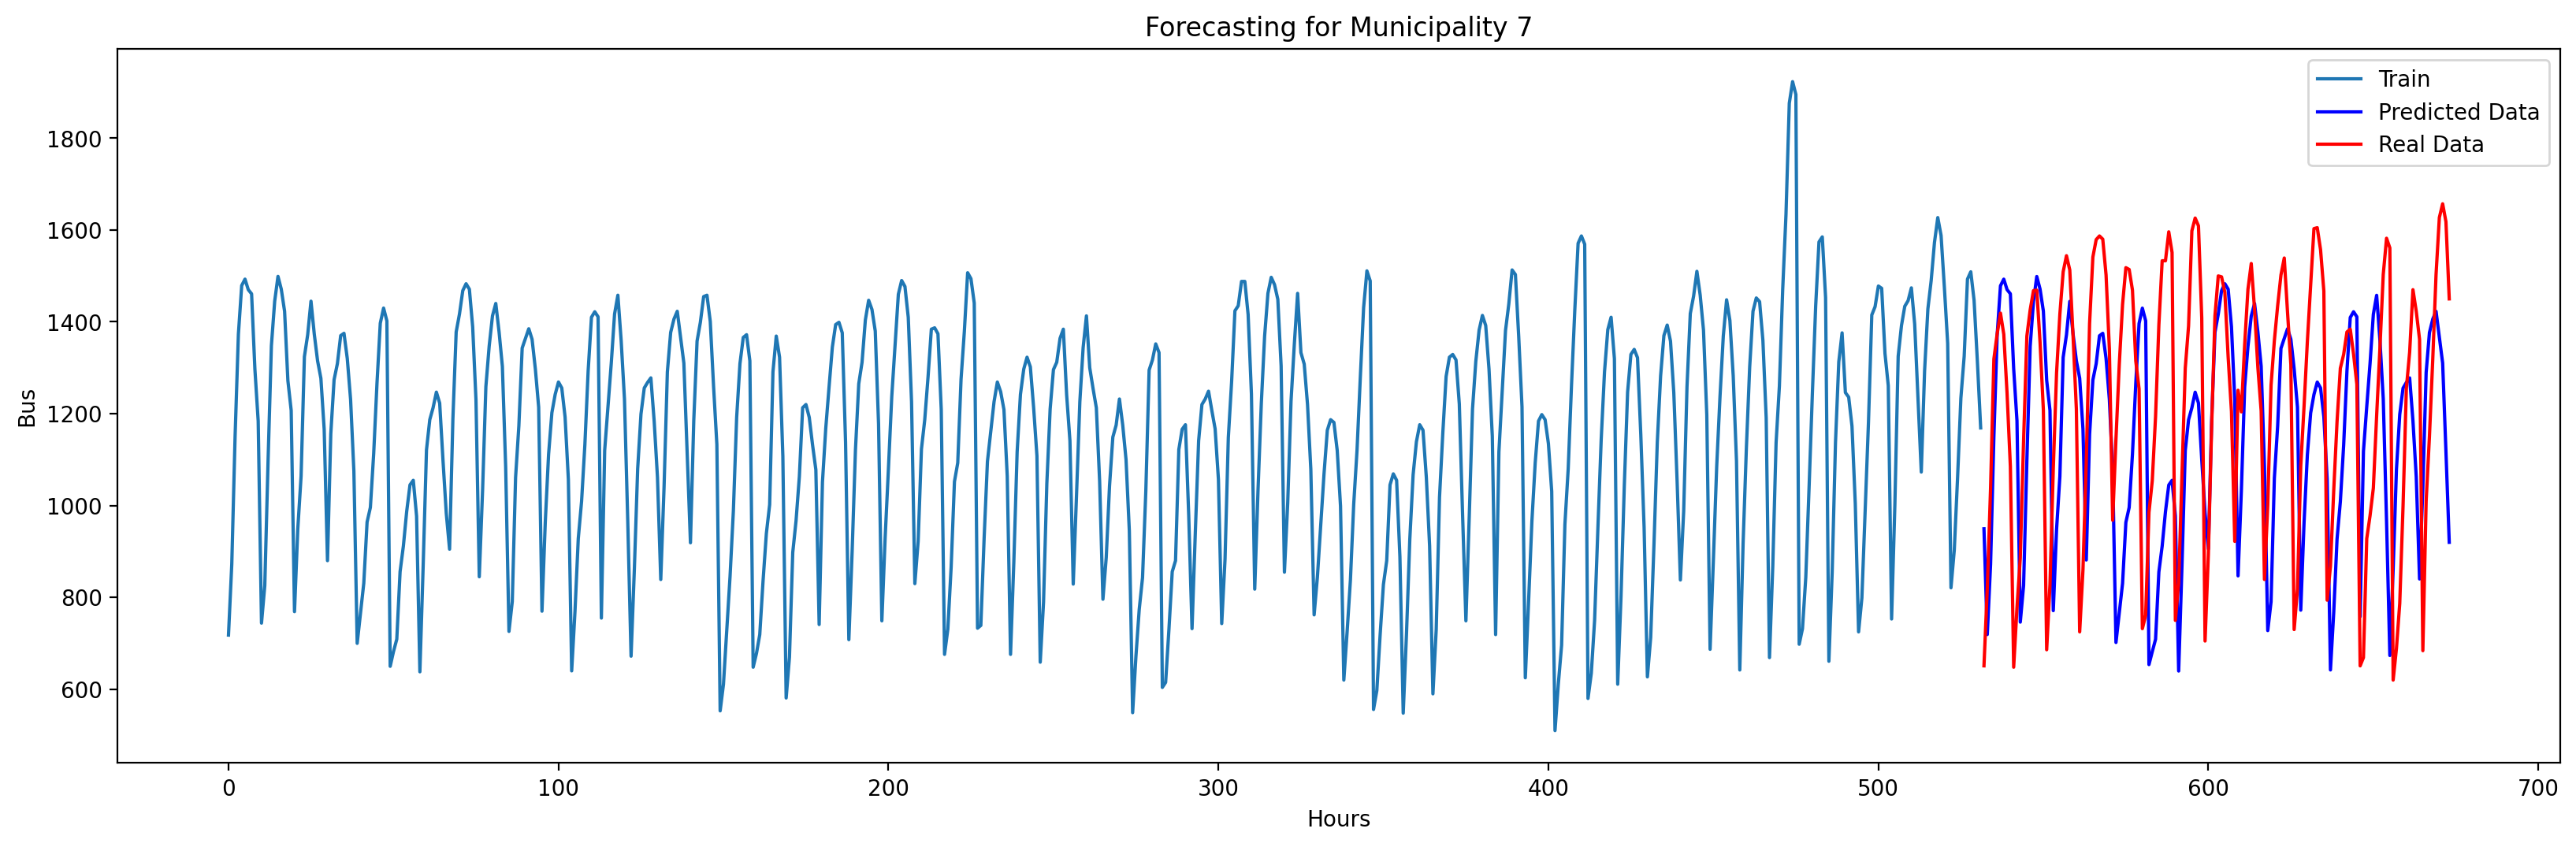

RMSE for Municipality 8: 333.1266


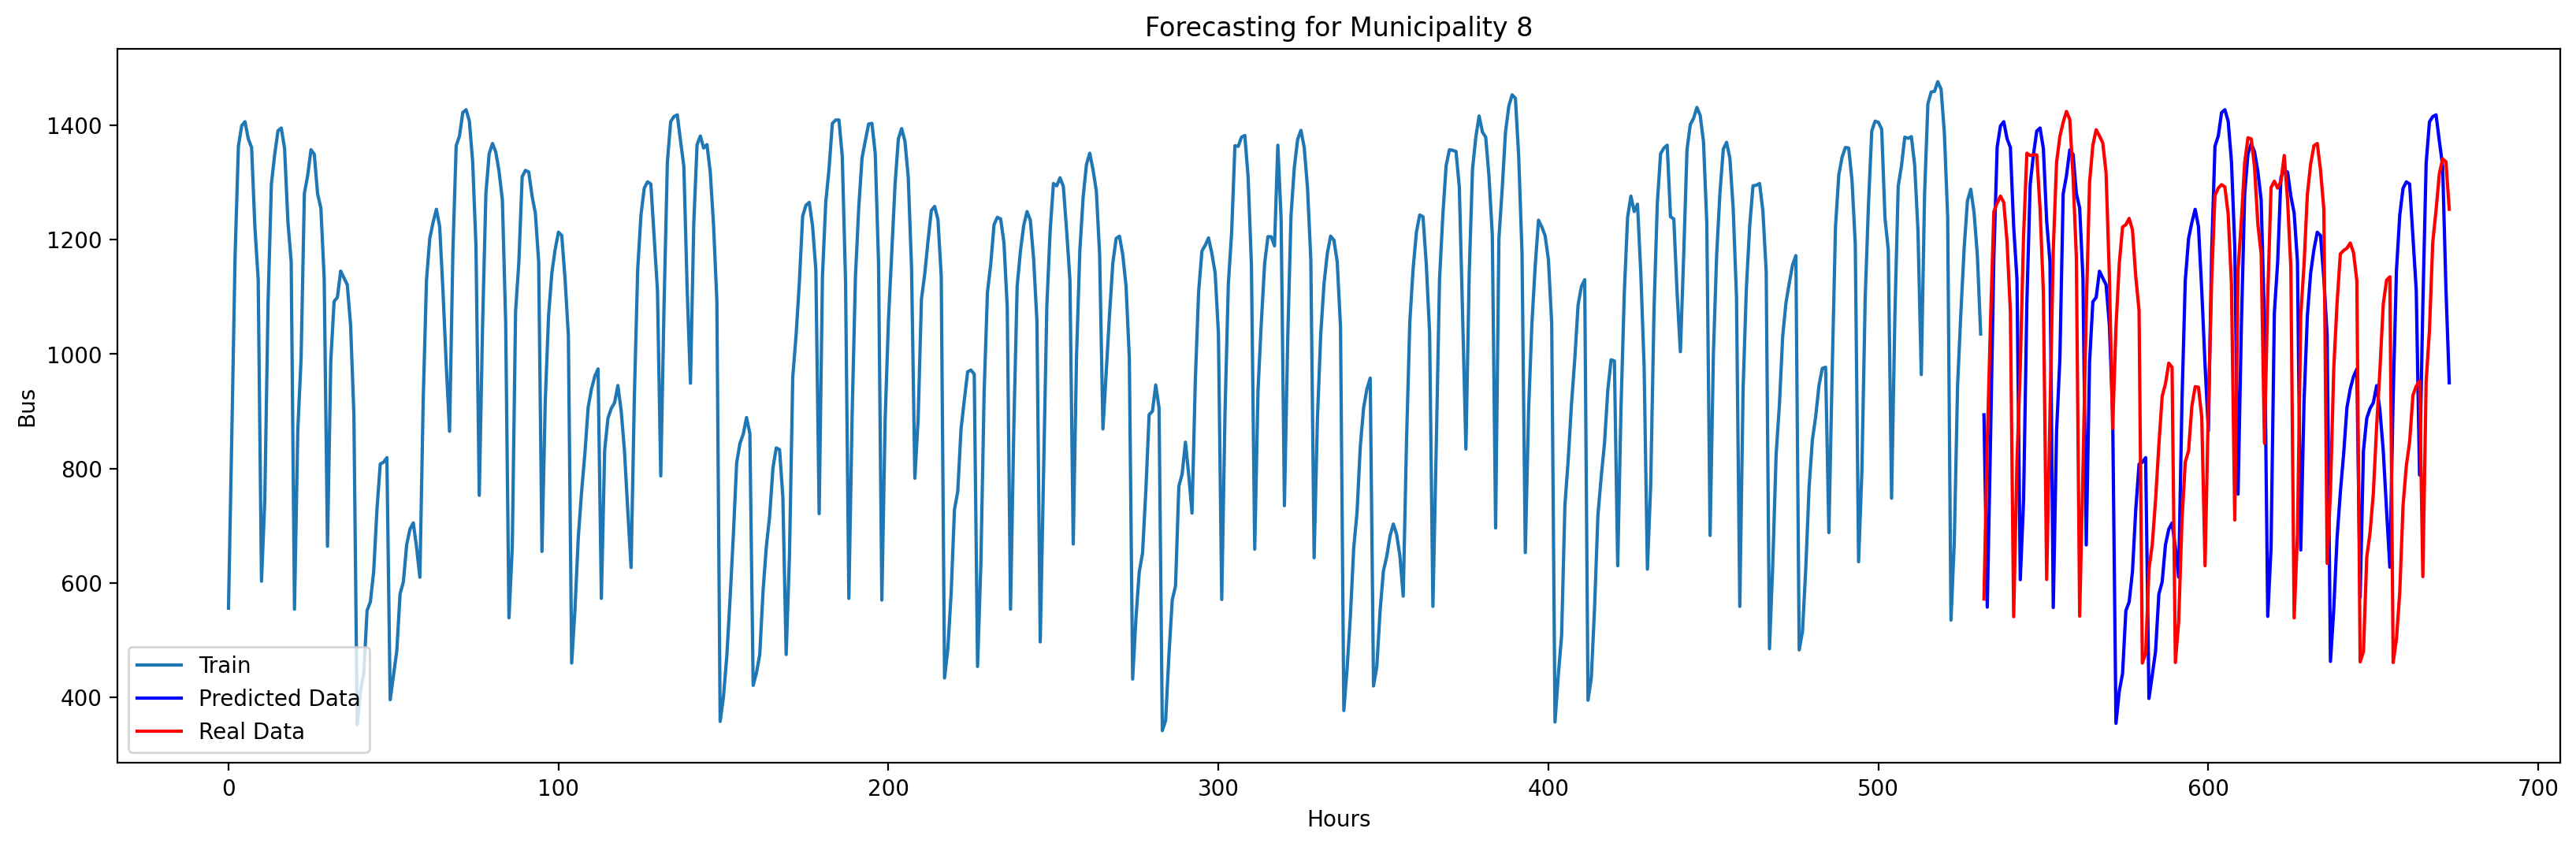

RMSE for Municipality 9: 208.3095


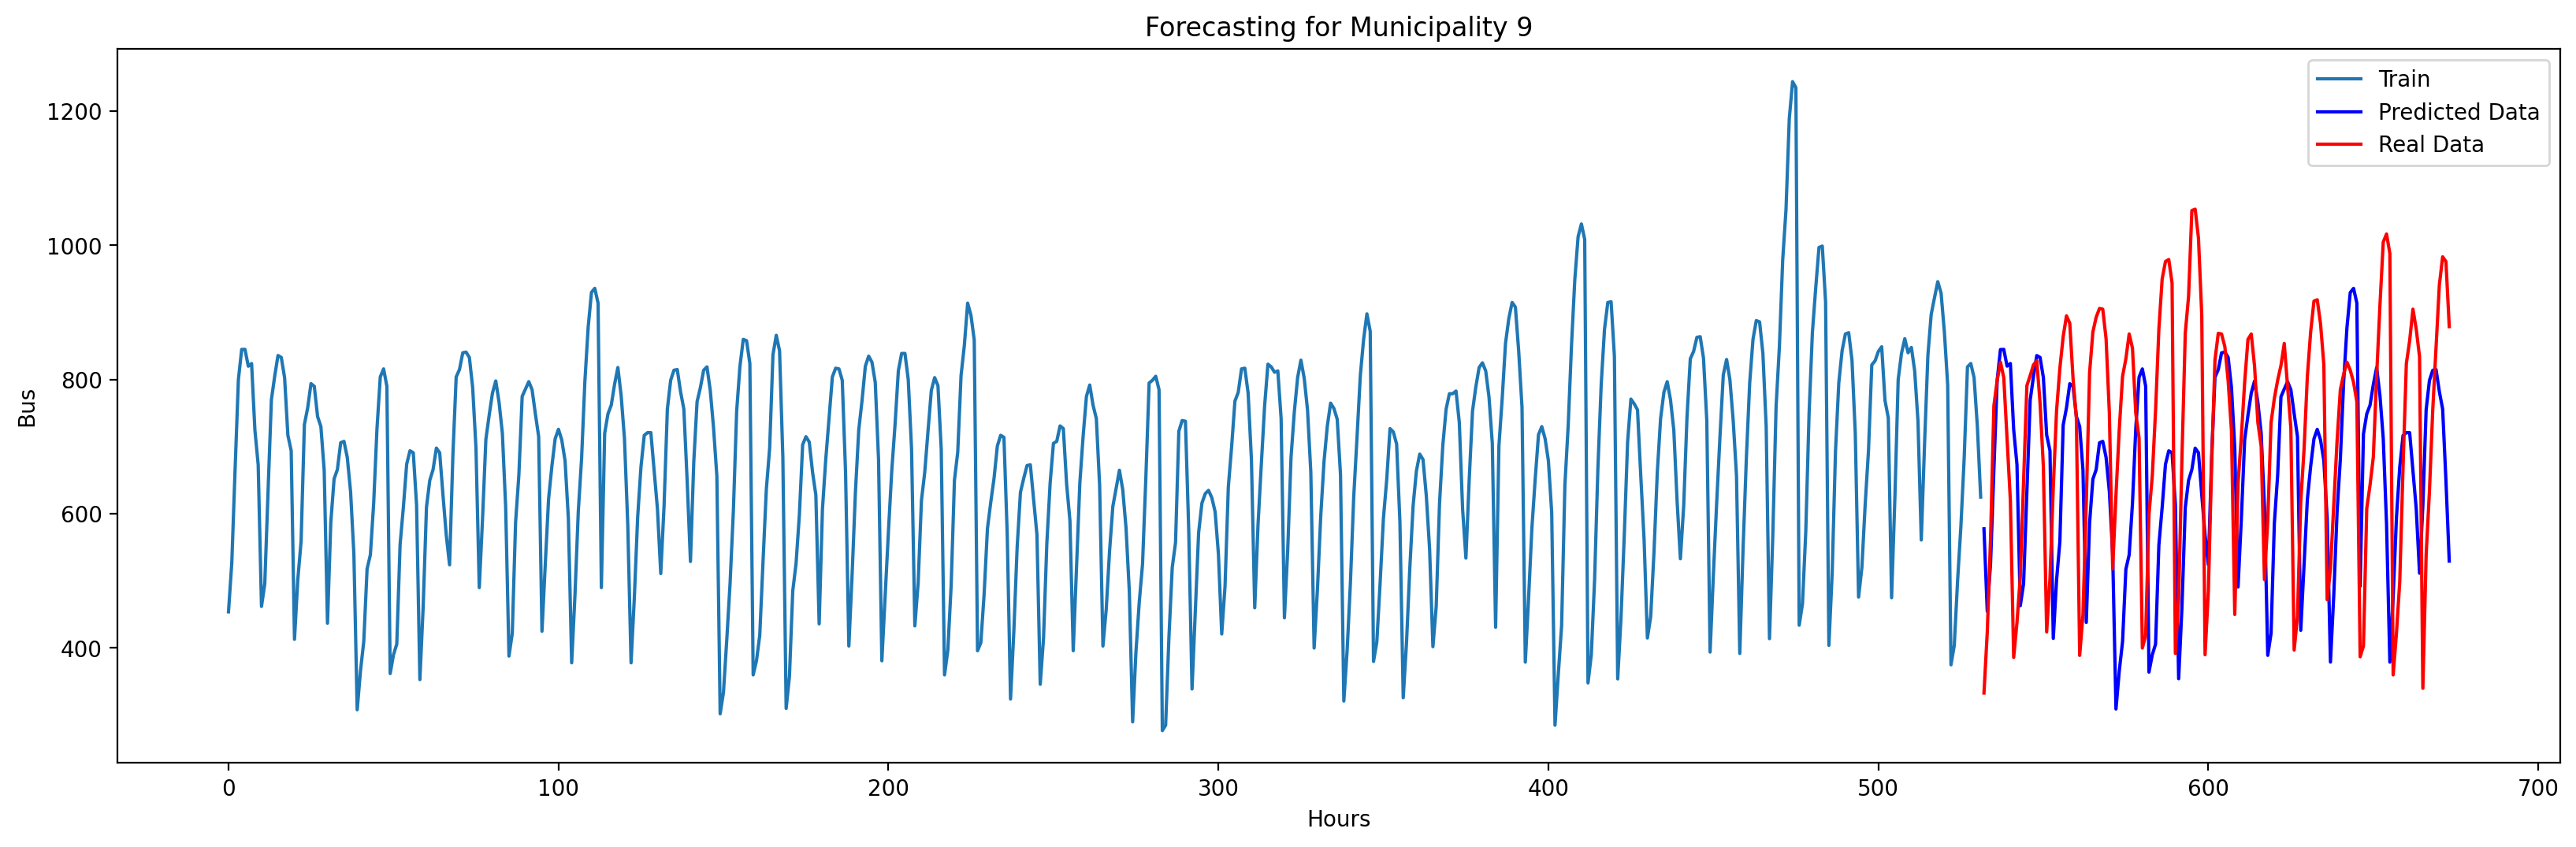

In [58]:
# Set up the train and test datasets
train_datas = train_data.copy()
test_datas = test_data.copy()

# Group the train and test datasets by Municipality_ID
train_datasets = [train_datas[train_datas['Municipality_ID'] == i].reset_index(drop=True) for i in range(10)]
test_datasets = [test_datas[test_datas['Municipality_ID'] == i].reset_index(drop=True) for i in range(10)]

# Loop through each train and test dataset and fit the ExponentialSmoothing model, make predictions, and plot the results
for i in range(10):
    # Fit the model on the train dataset
    model = ExponentialSmoothing(train_datasets[i]['Usage'], trend=None, seasonal=None, seasonal_periods=None)
    hw_model = model.fit(optimized=True, remove_bias=False)
    
    # Make predictions on the test dataset
    predictions = hw_model.predict(start=test_datasets[i]['Usage'].index[0], end=test_datasets[i]['Usage'].index[-1])
    predictions.index += len(train_datasets[i])
    test_datasets[i].index += len(train_datasets[i])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_datasets[i]["Usage"], predictions))
    print(f"RMSE for Municipality {i}: {rmse:.4f}")
    
    # Plot the actual vs. predicted values
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(train_datasets[i]["Usage"].index, train_datasets[i]["Usage"], label='Train')
    plt.plot(predictions.index, predictions, 'b-', label = 'Predicted Data')
    plt.plot(test_datasets[i]["Usage"].index, test_datasets[i]["Usage"], 'r-', label = 'Real Data')
    plt.xlabel('Hours')
    plt.ylabel('Bus')
    plt.title(f'Forecasting for Municipality {i}')
    plt.legend(loc="best")
    plt.show()



## Forecasting with CNN algorithm

5/5 [==============================] - 0s 994us/step
RMSE for Municipality 0: 171.1170


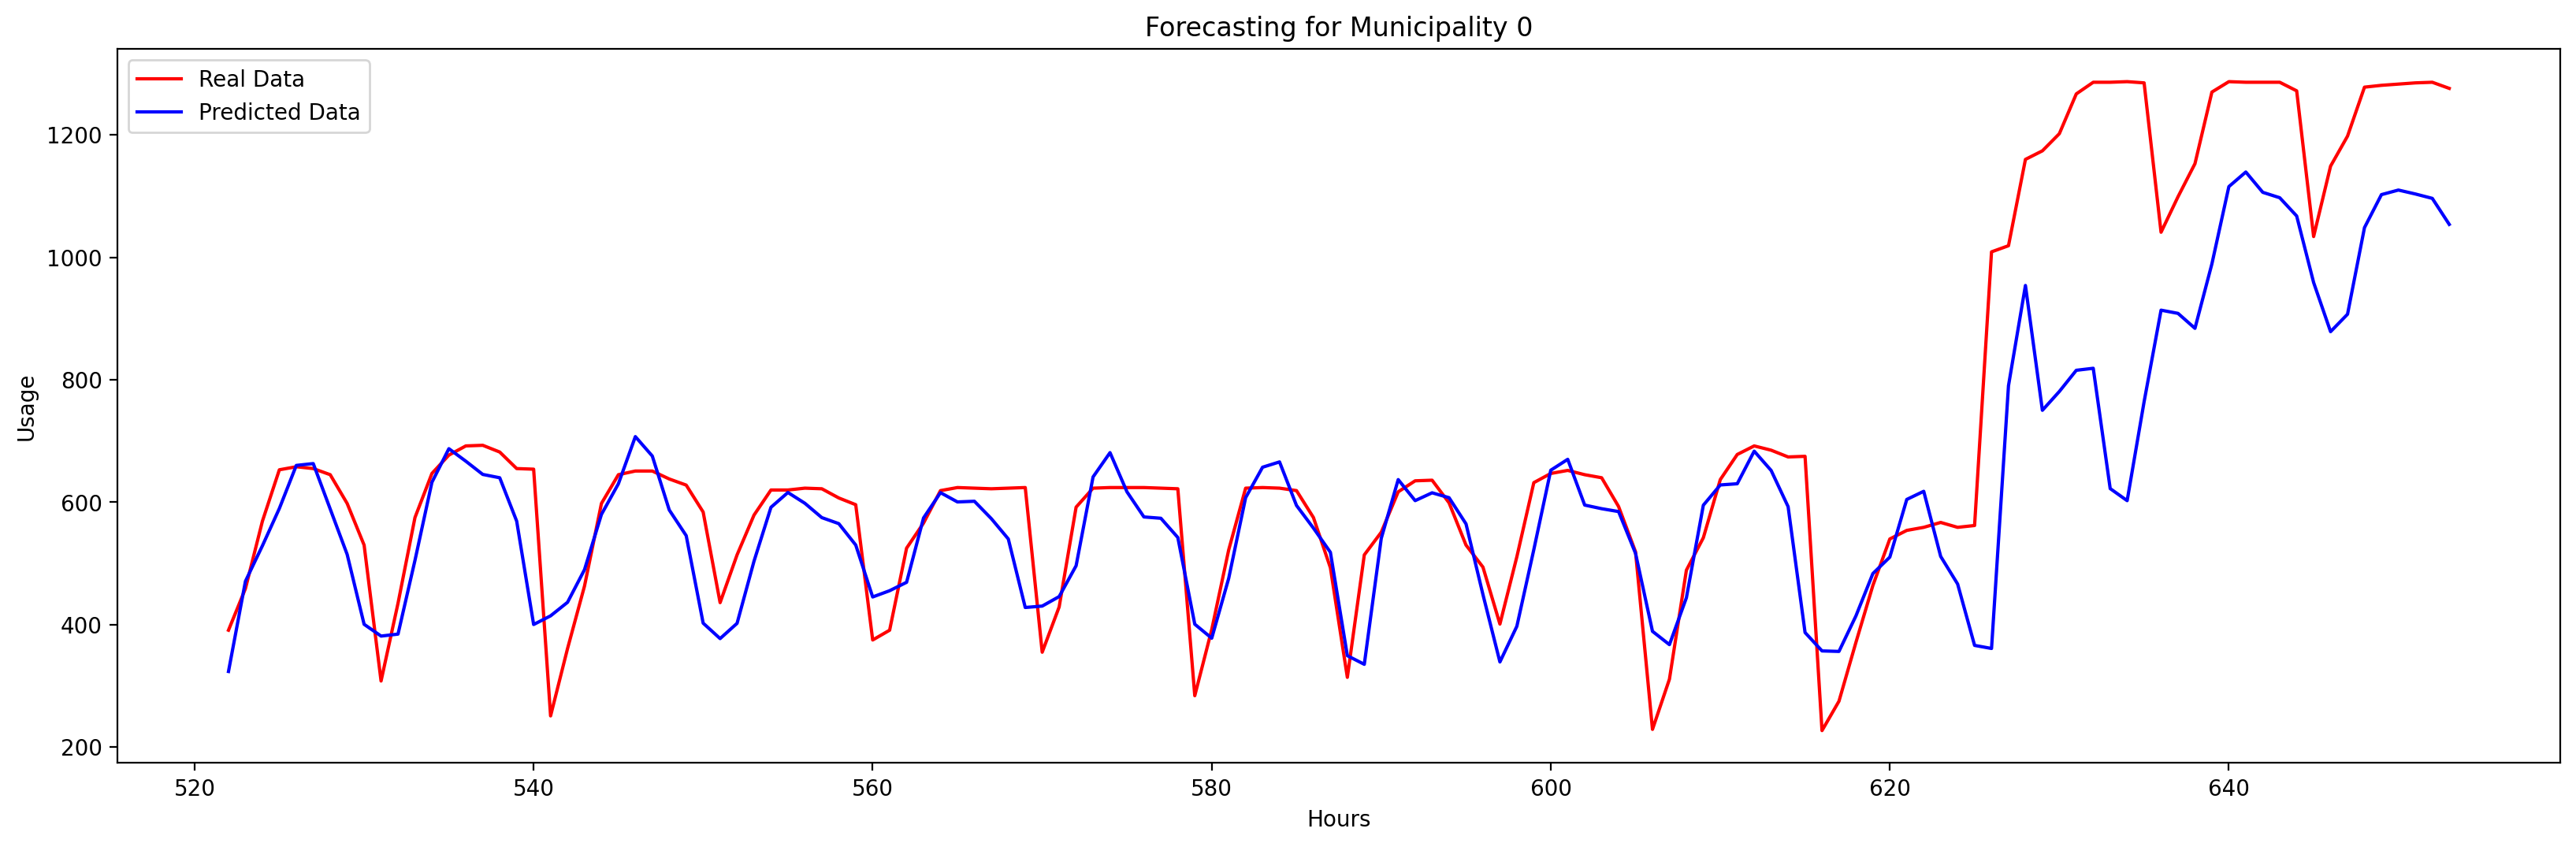

5/5 [==============================] - 0s 983us/step
RMSE for Municipality 1: 46.9981


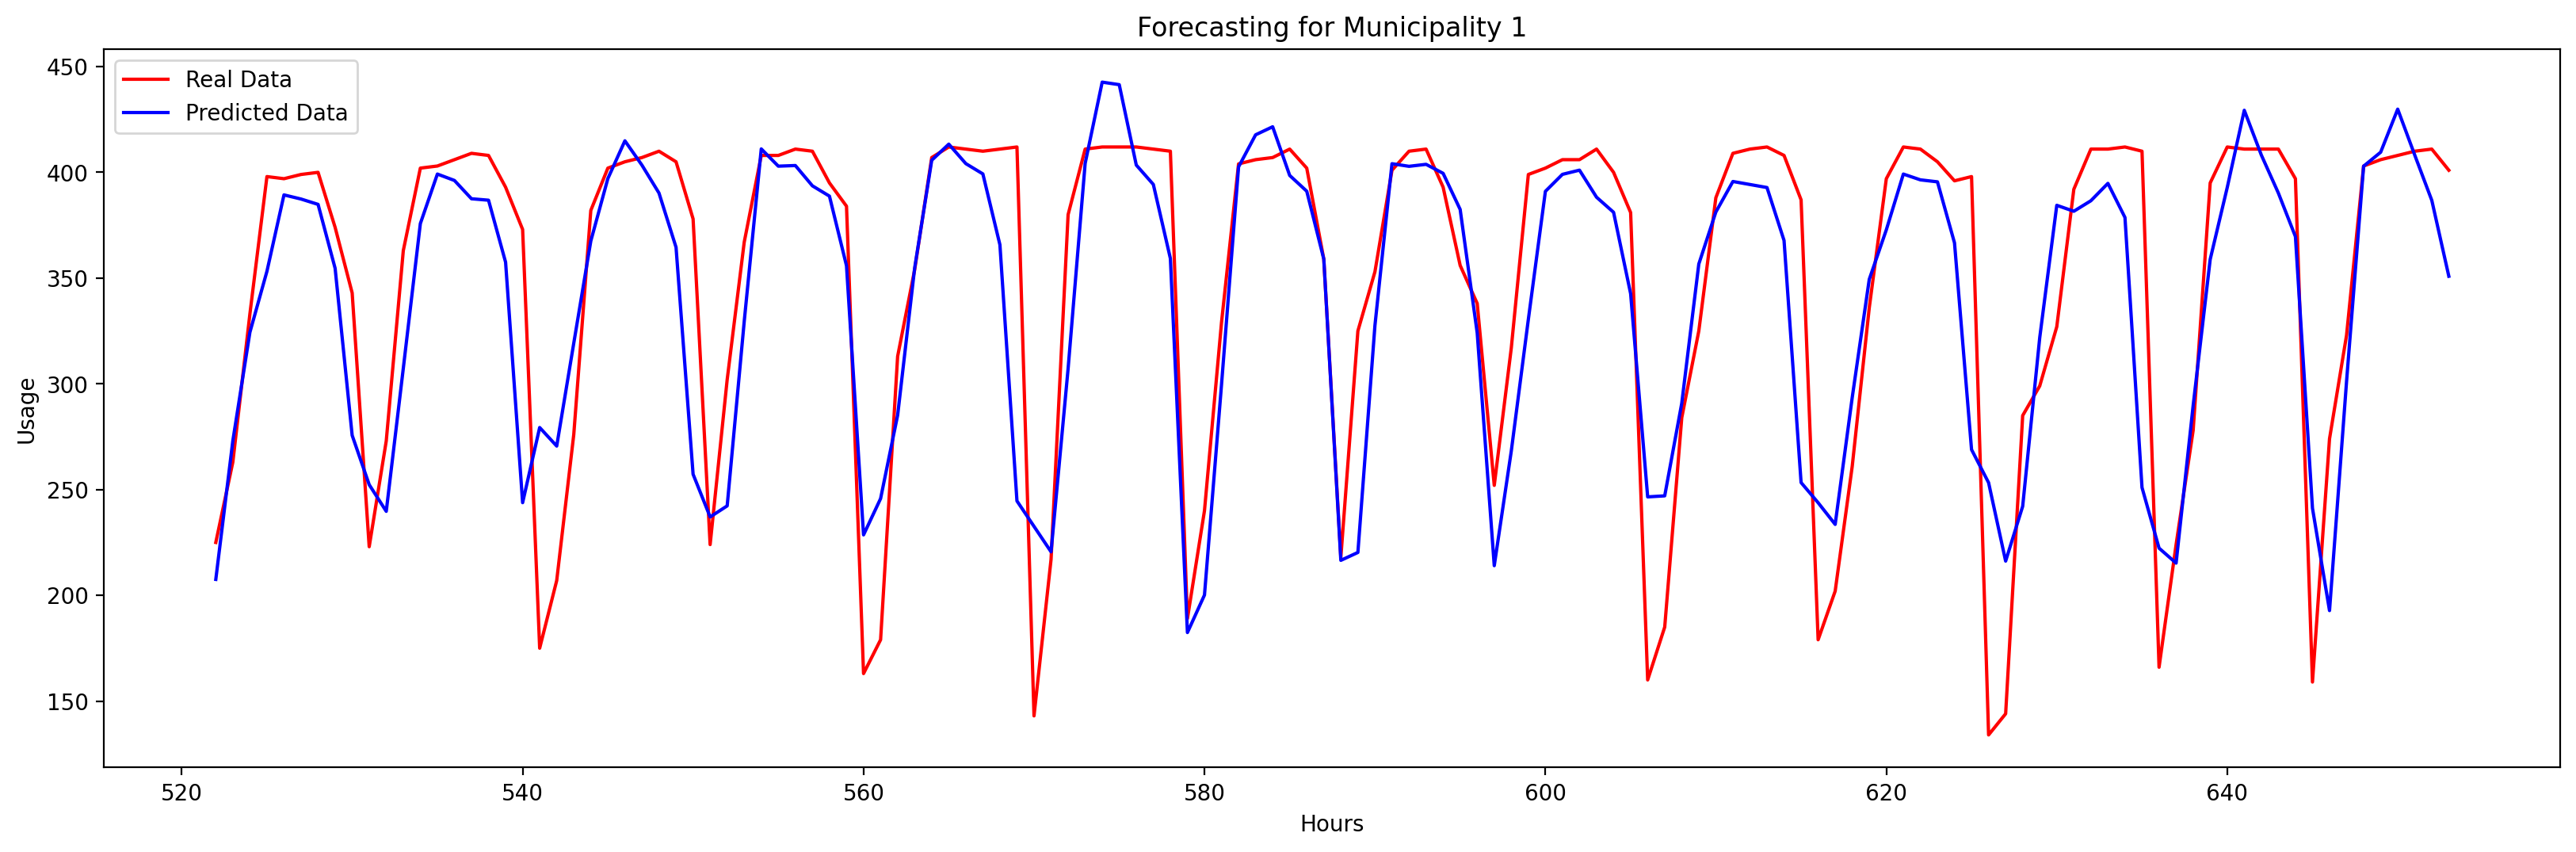

5/5 [==============================] - 0s 1ms/step
RMSE for Municipality 2: 66.8967


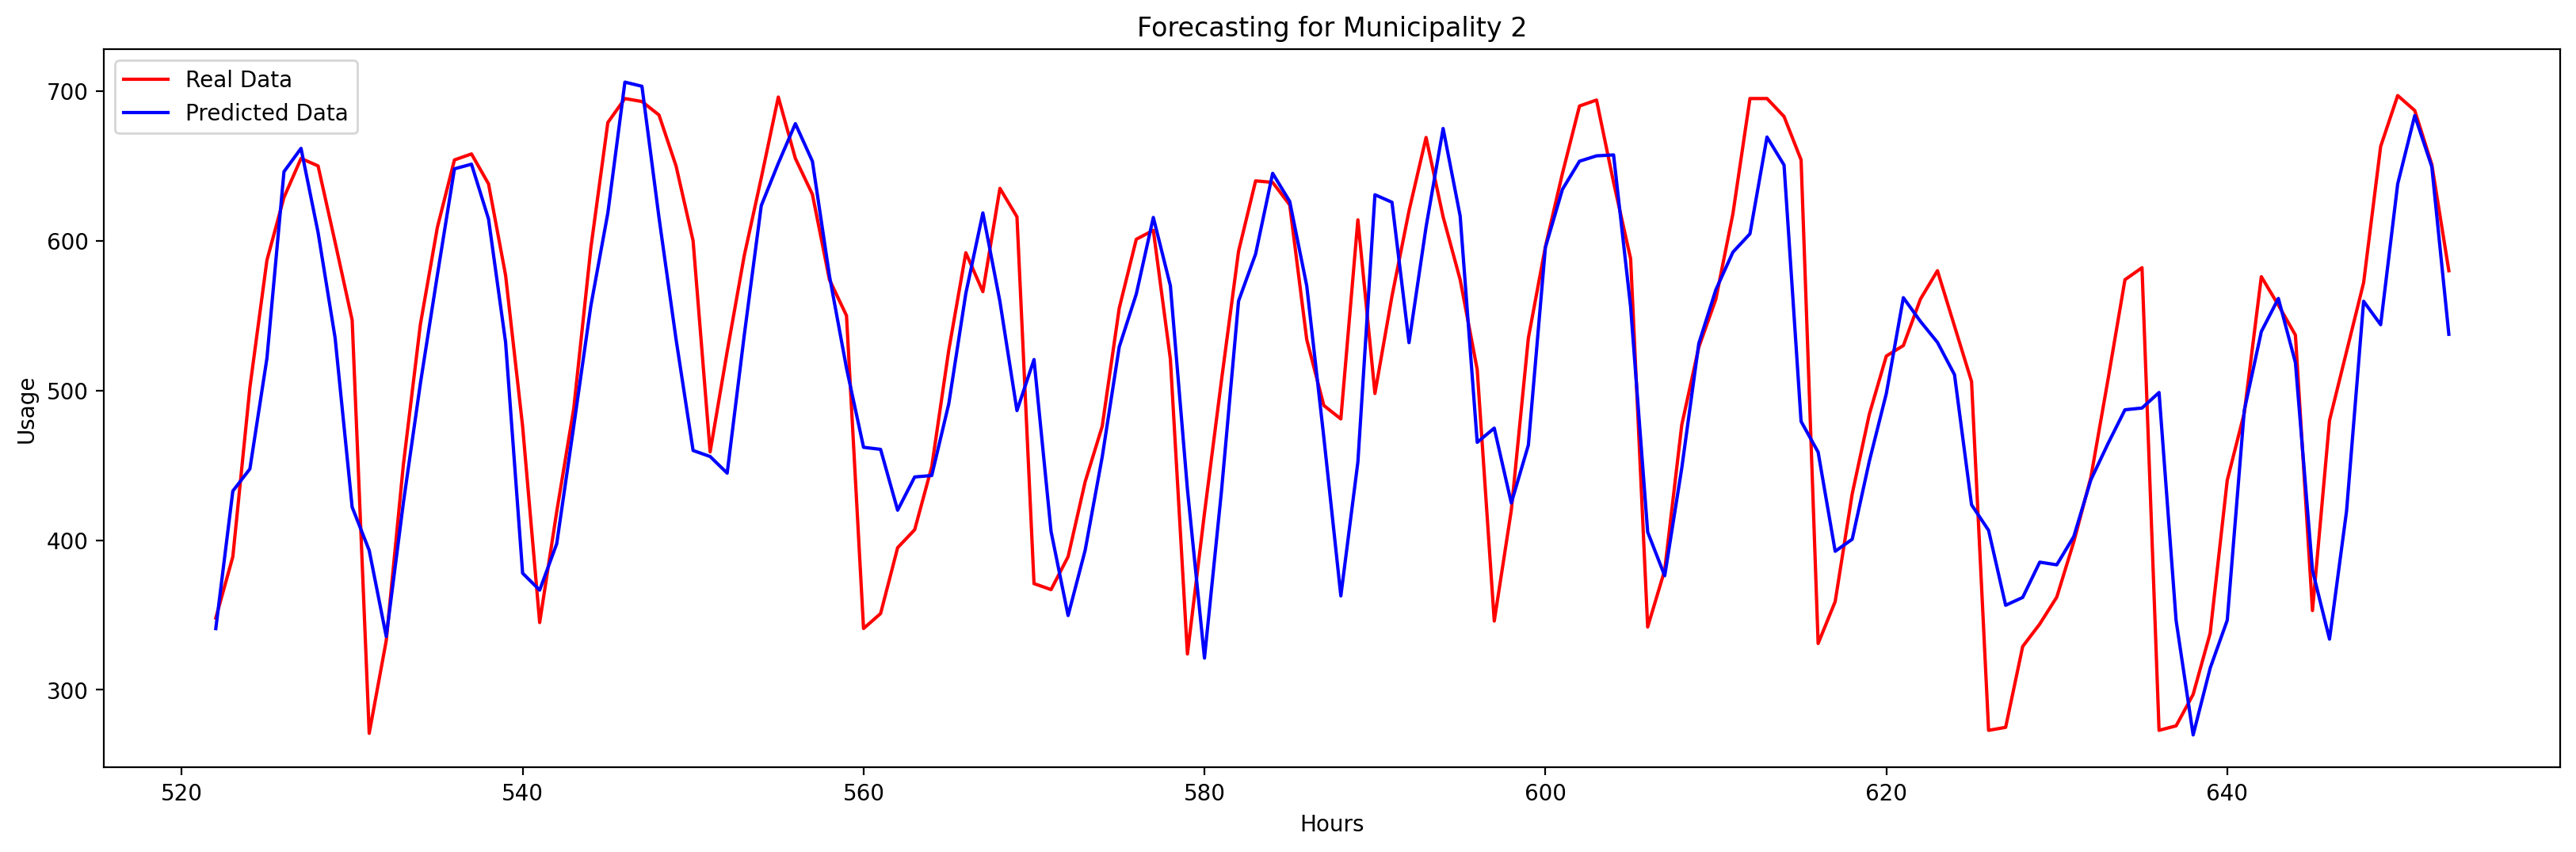

5/5 [==============================] - 0s 1ms/step
RMSE for Municipality 3: 154.1827


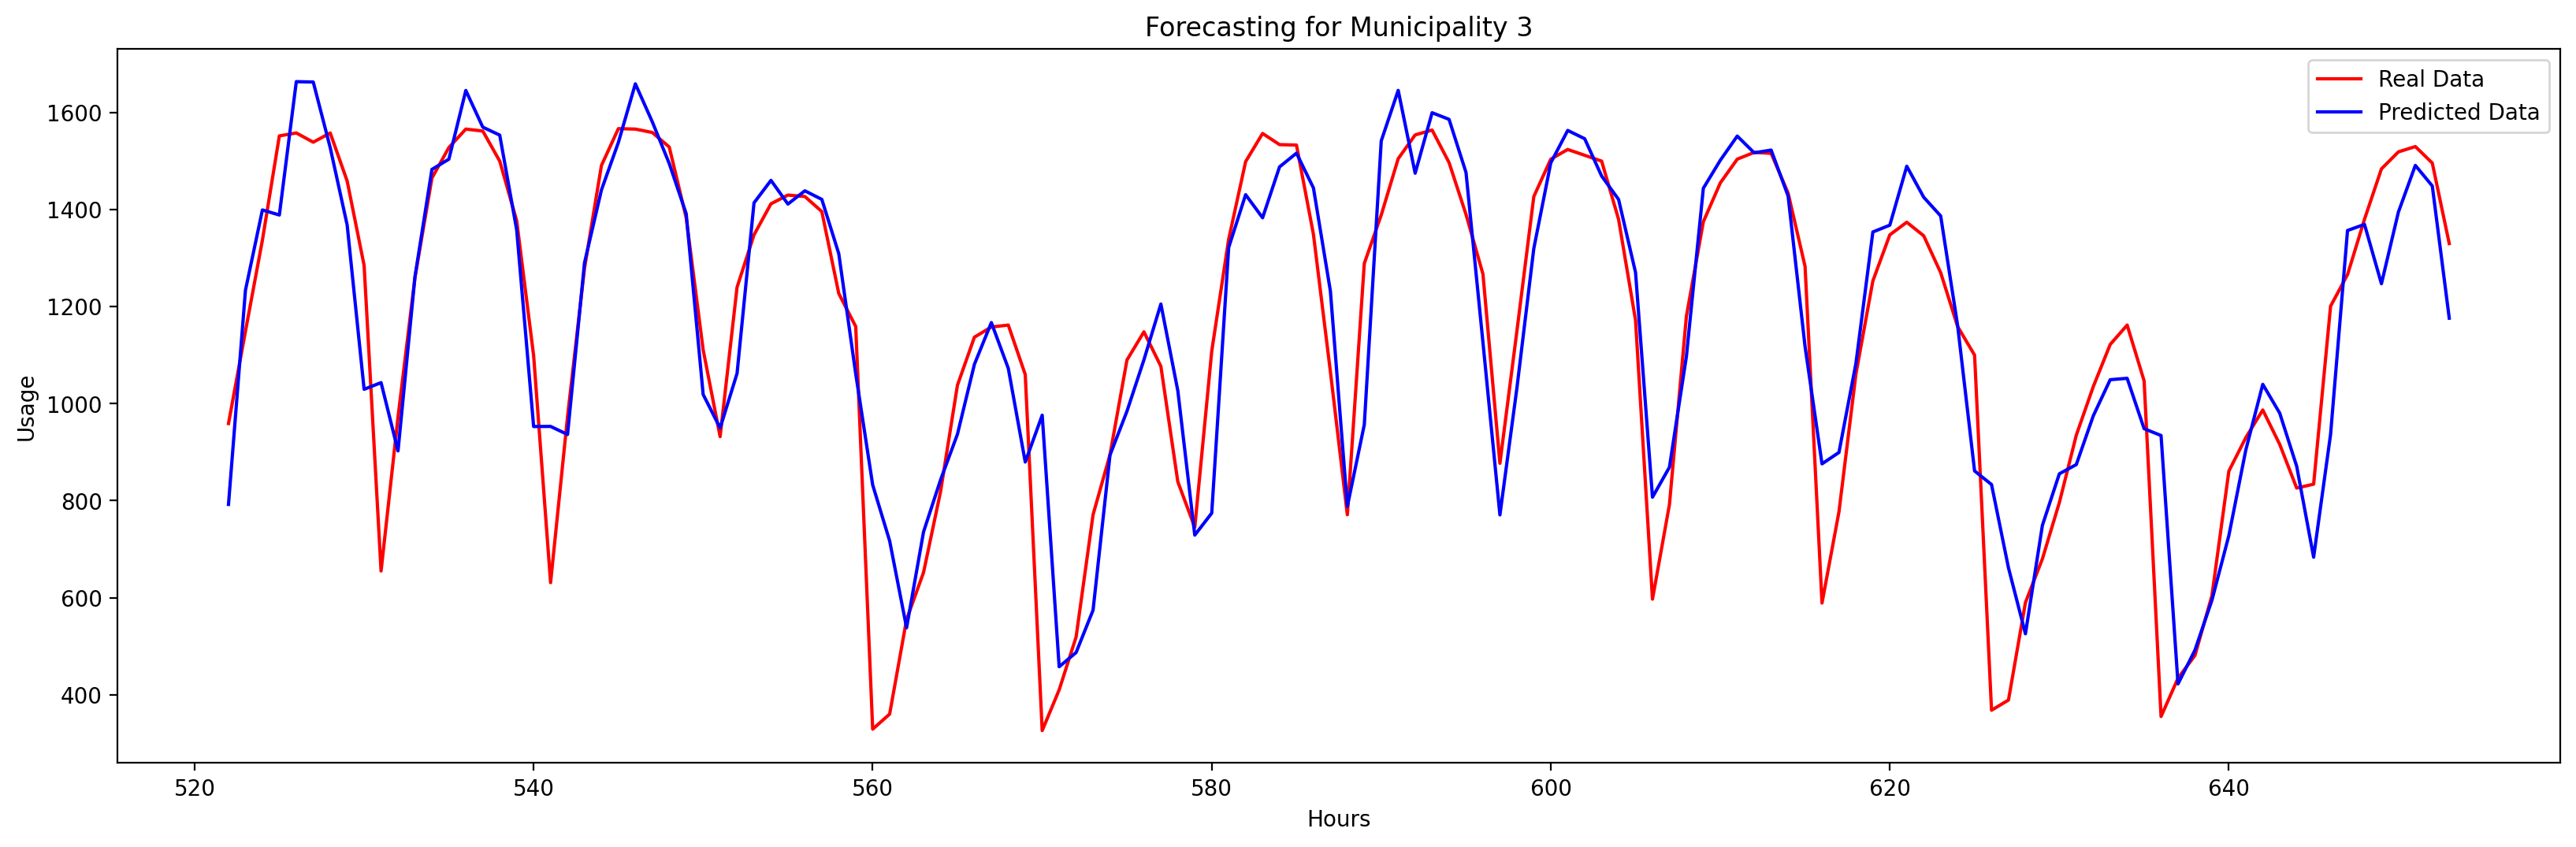

5/5 [==============================] - 0s 998us/step
RMSE for Municipality 4: 336.7585


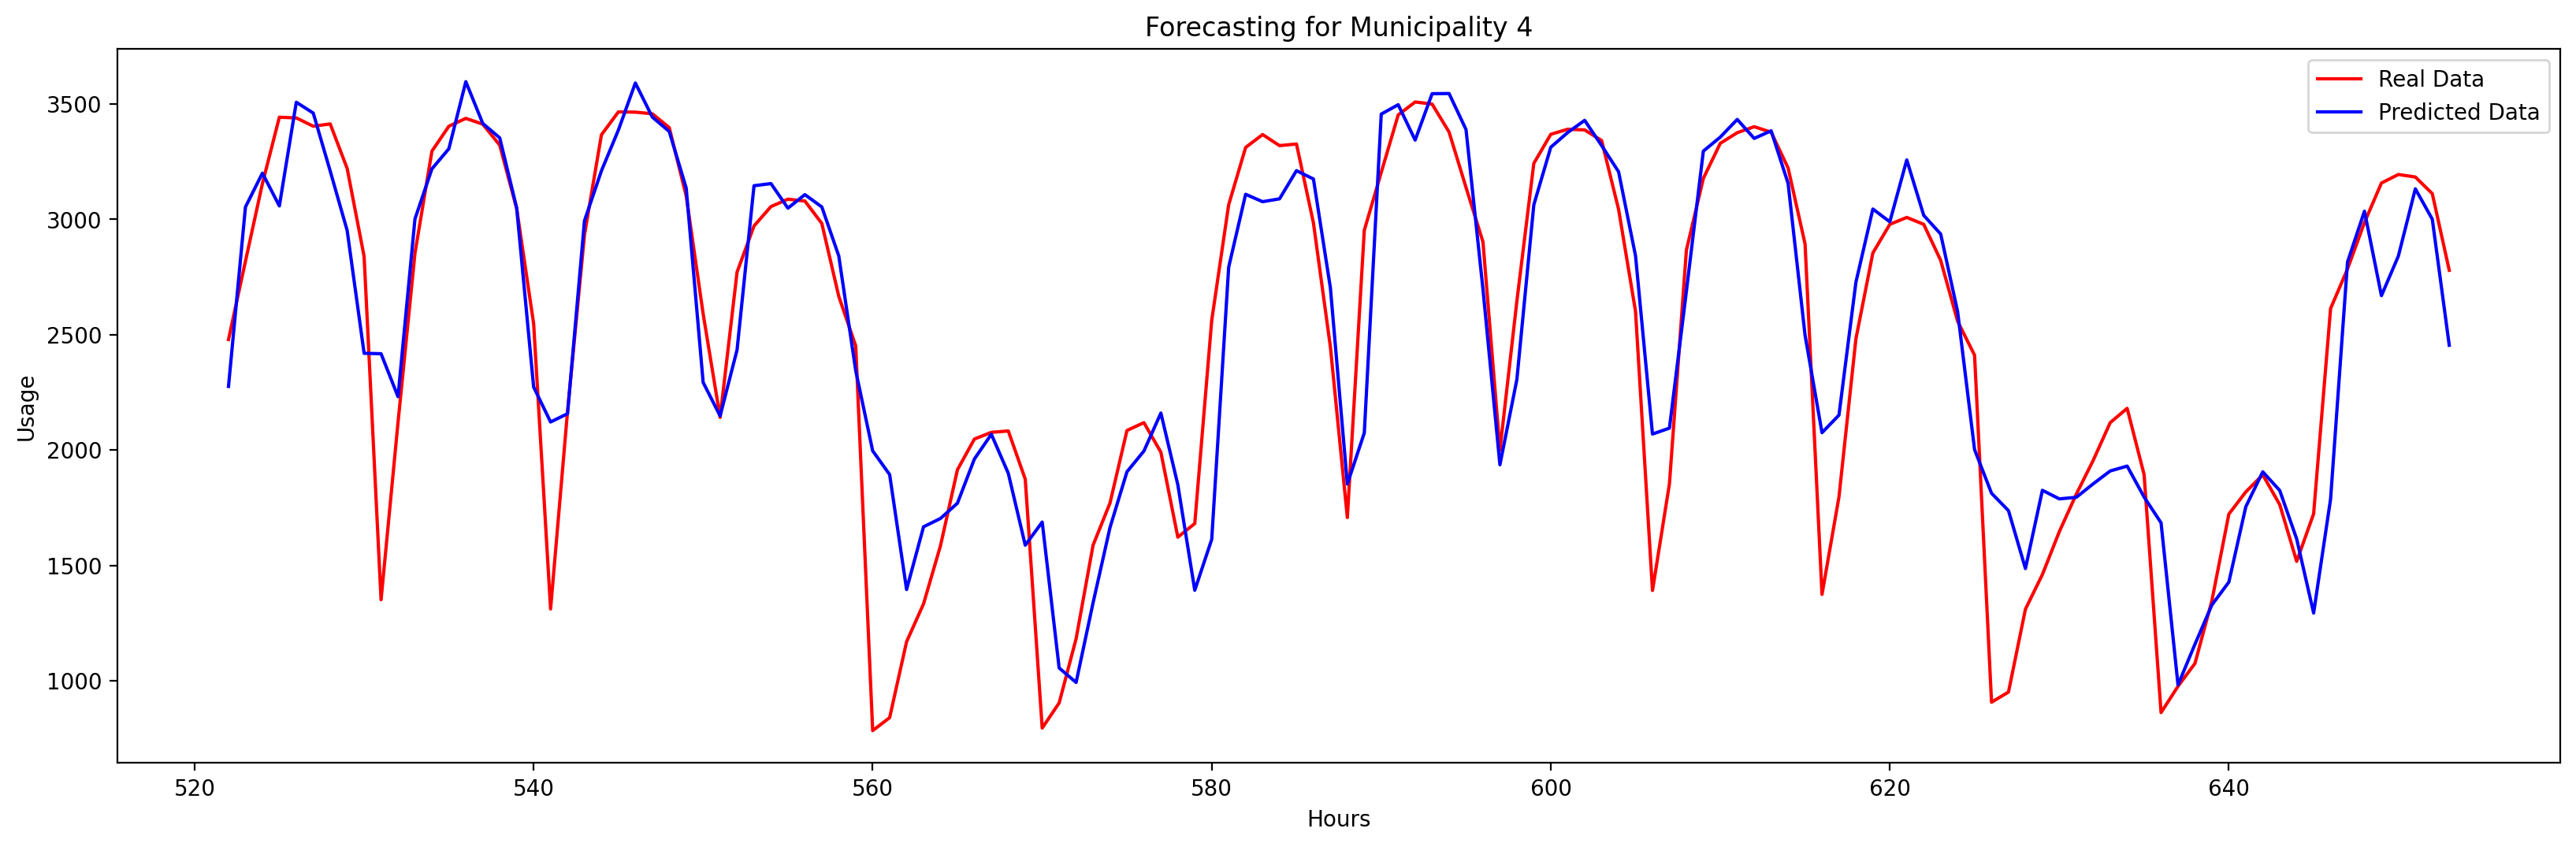

5/5 [==============================] - 0s 973us/step
RMSE for Municipality 5: 39.3344


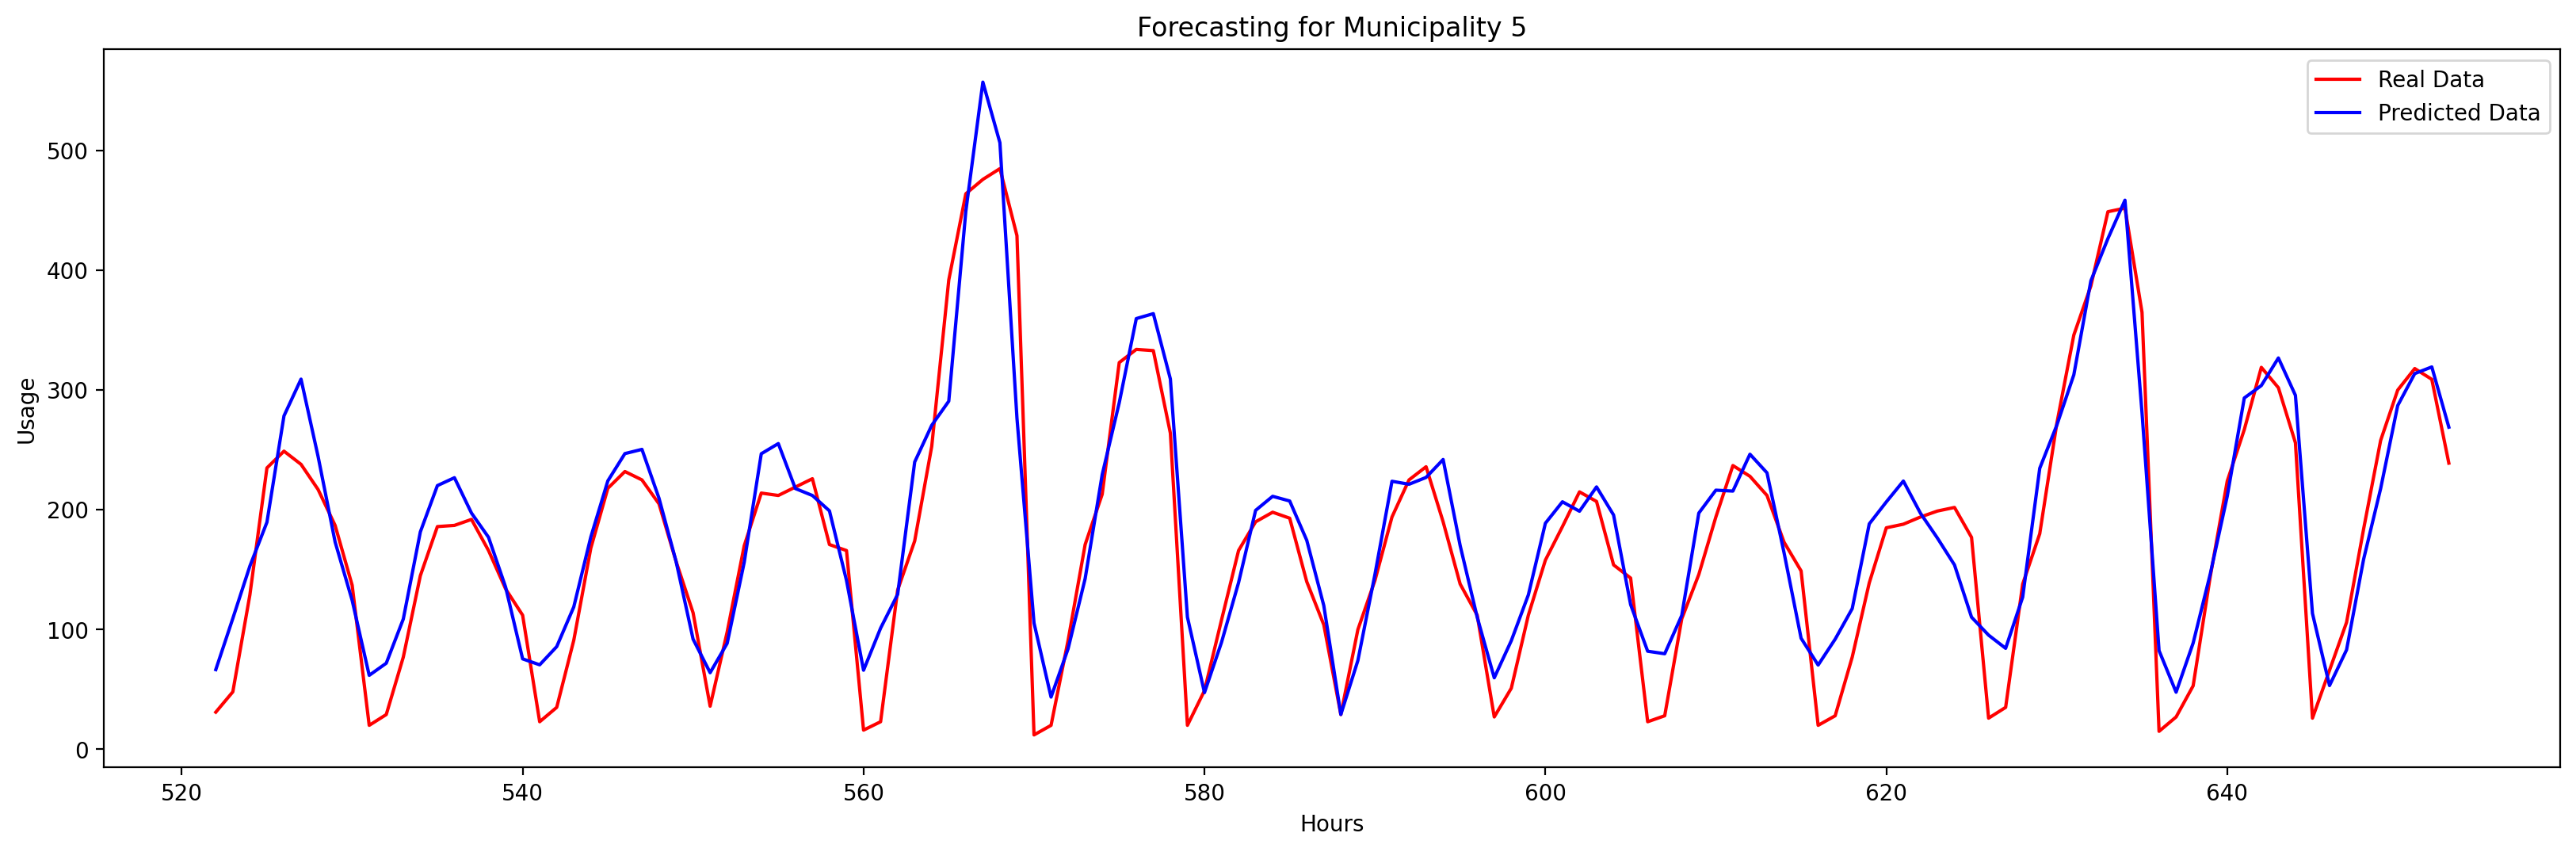

5/5 [==============================] - 0s 1ms/step
RMSE for Municipality 6: 145.4946


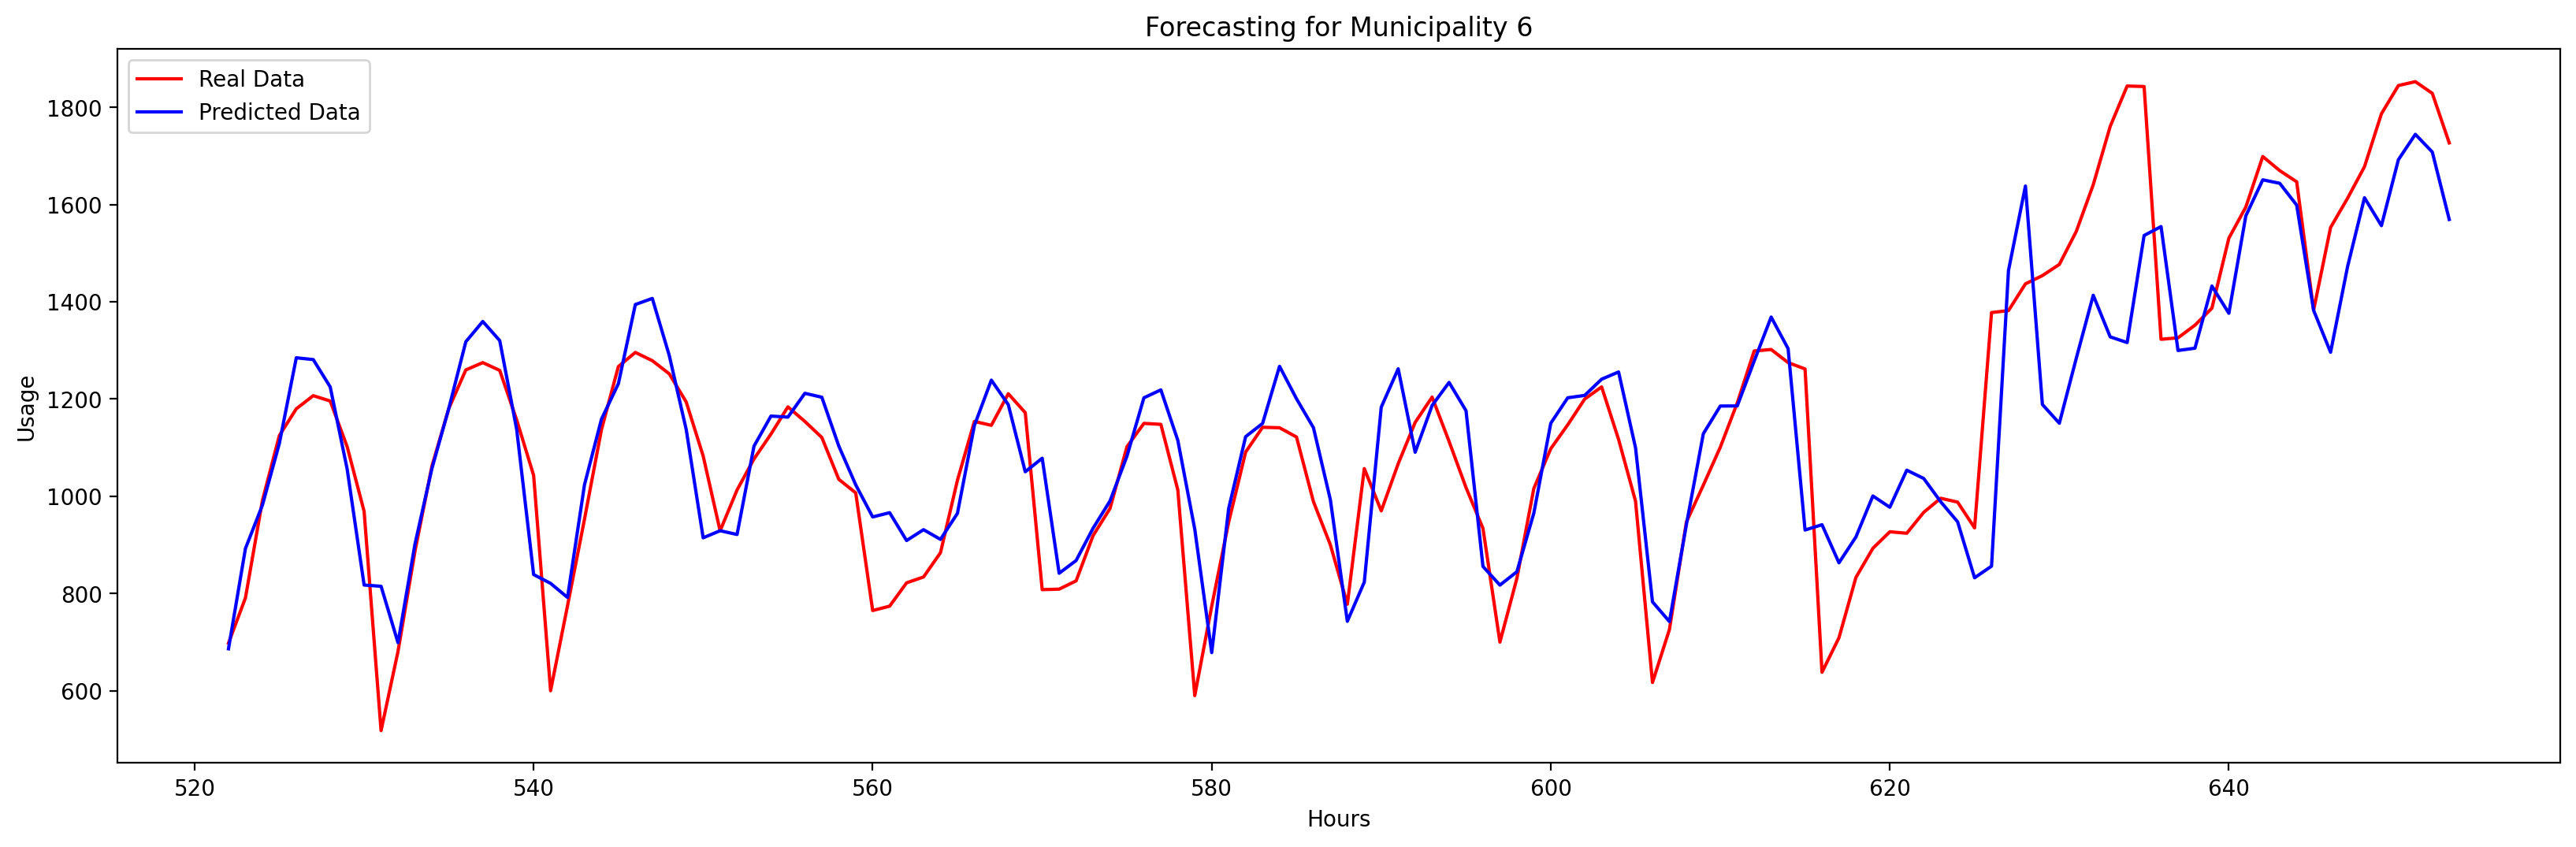

5/5 [==============================] - 0s 1ms/step
RMSE for Municipality 7: 136.7220


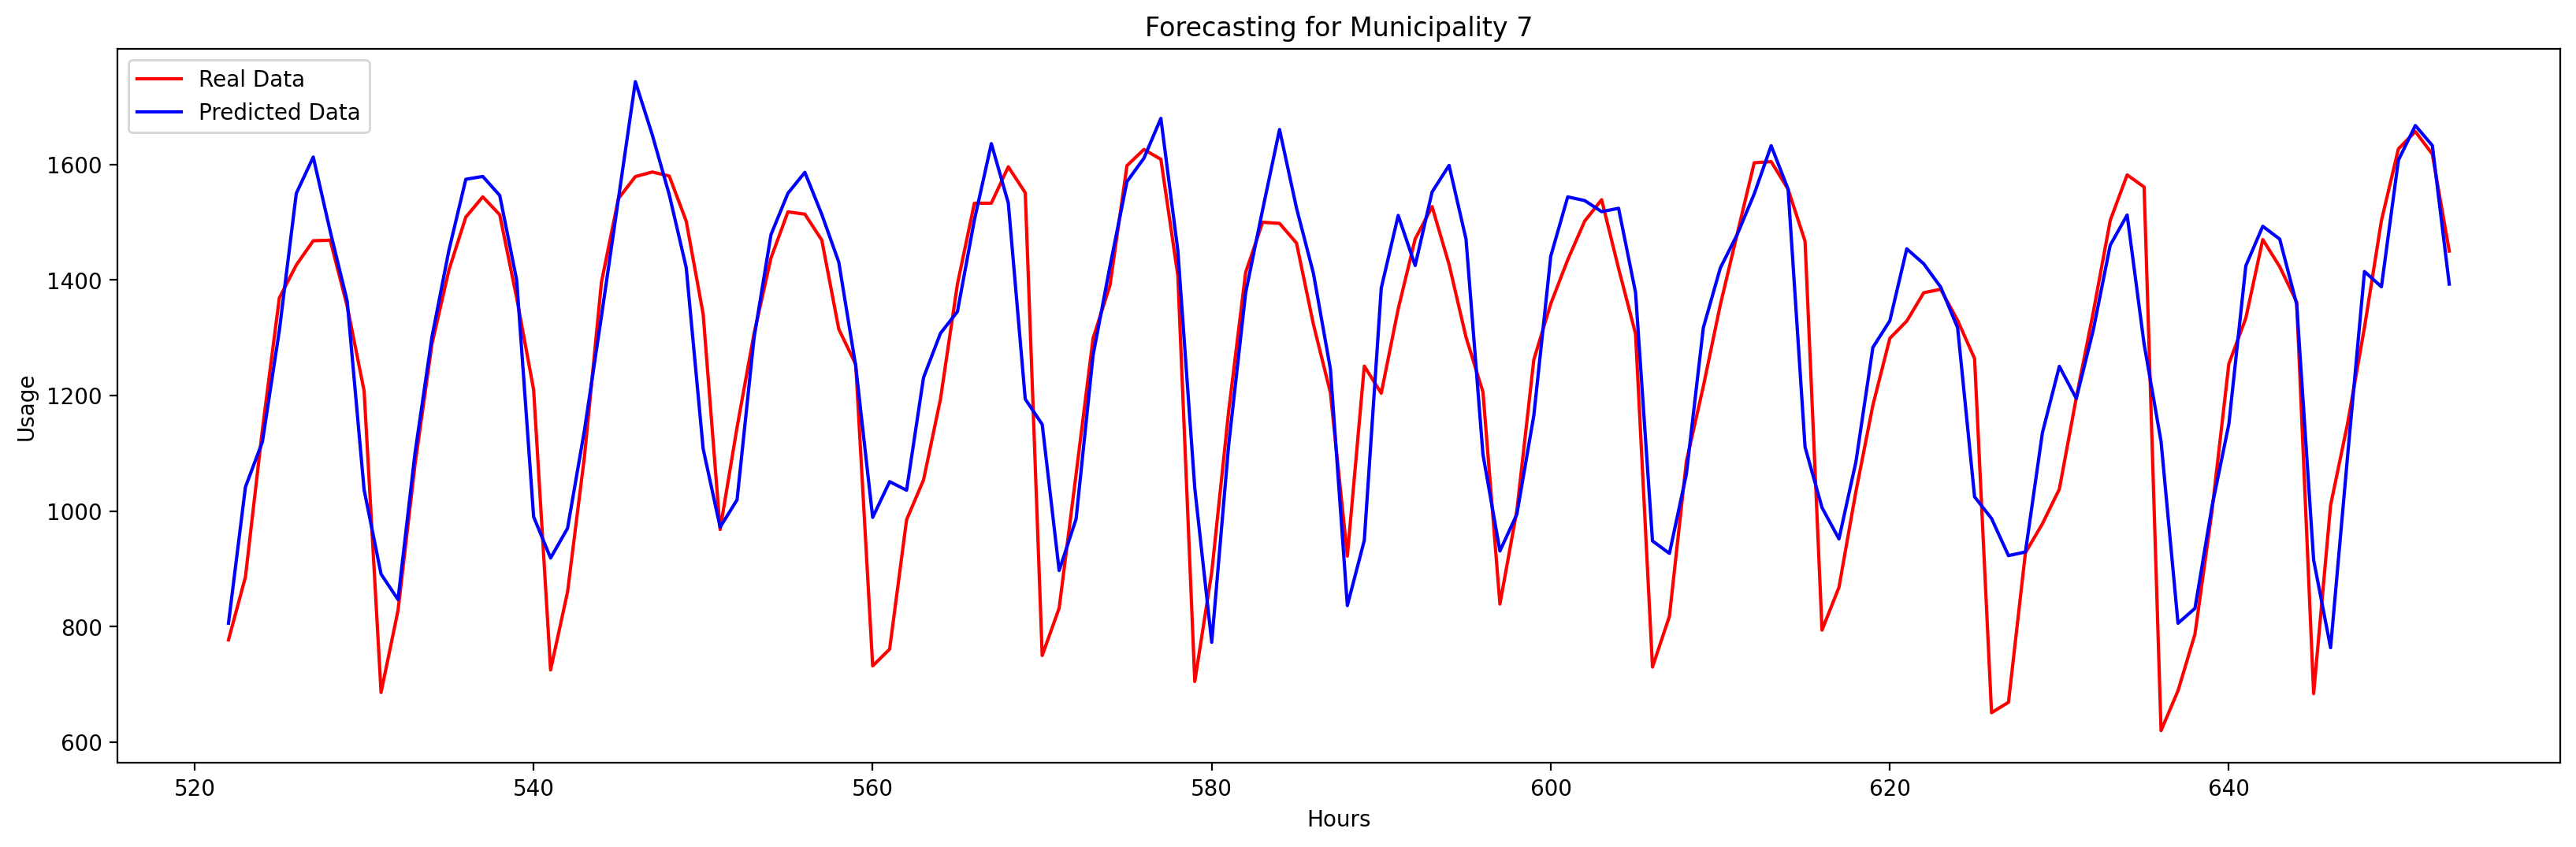

5/5 [==============================] - 0s 929us/step
RMSE for Municipality 8: 136.9544


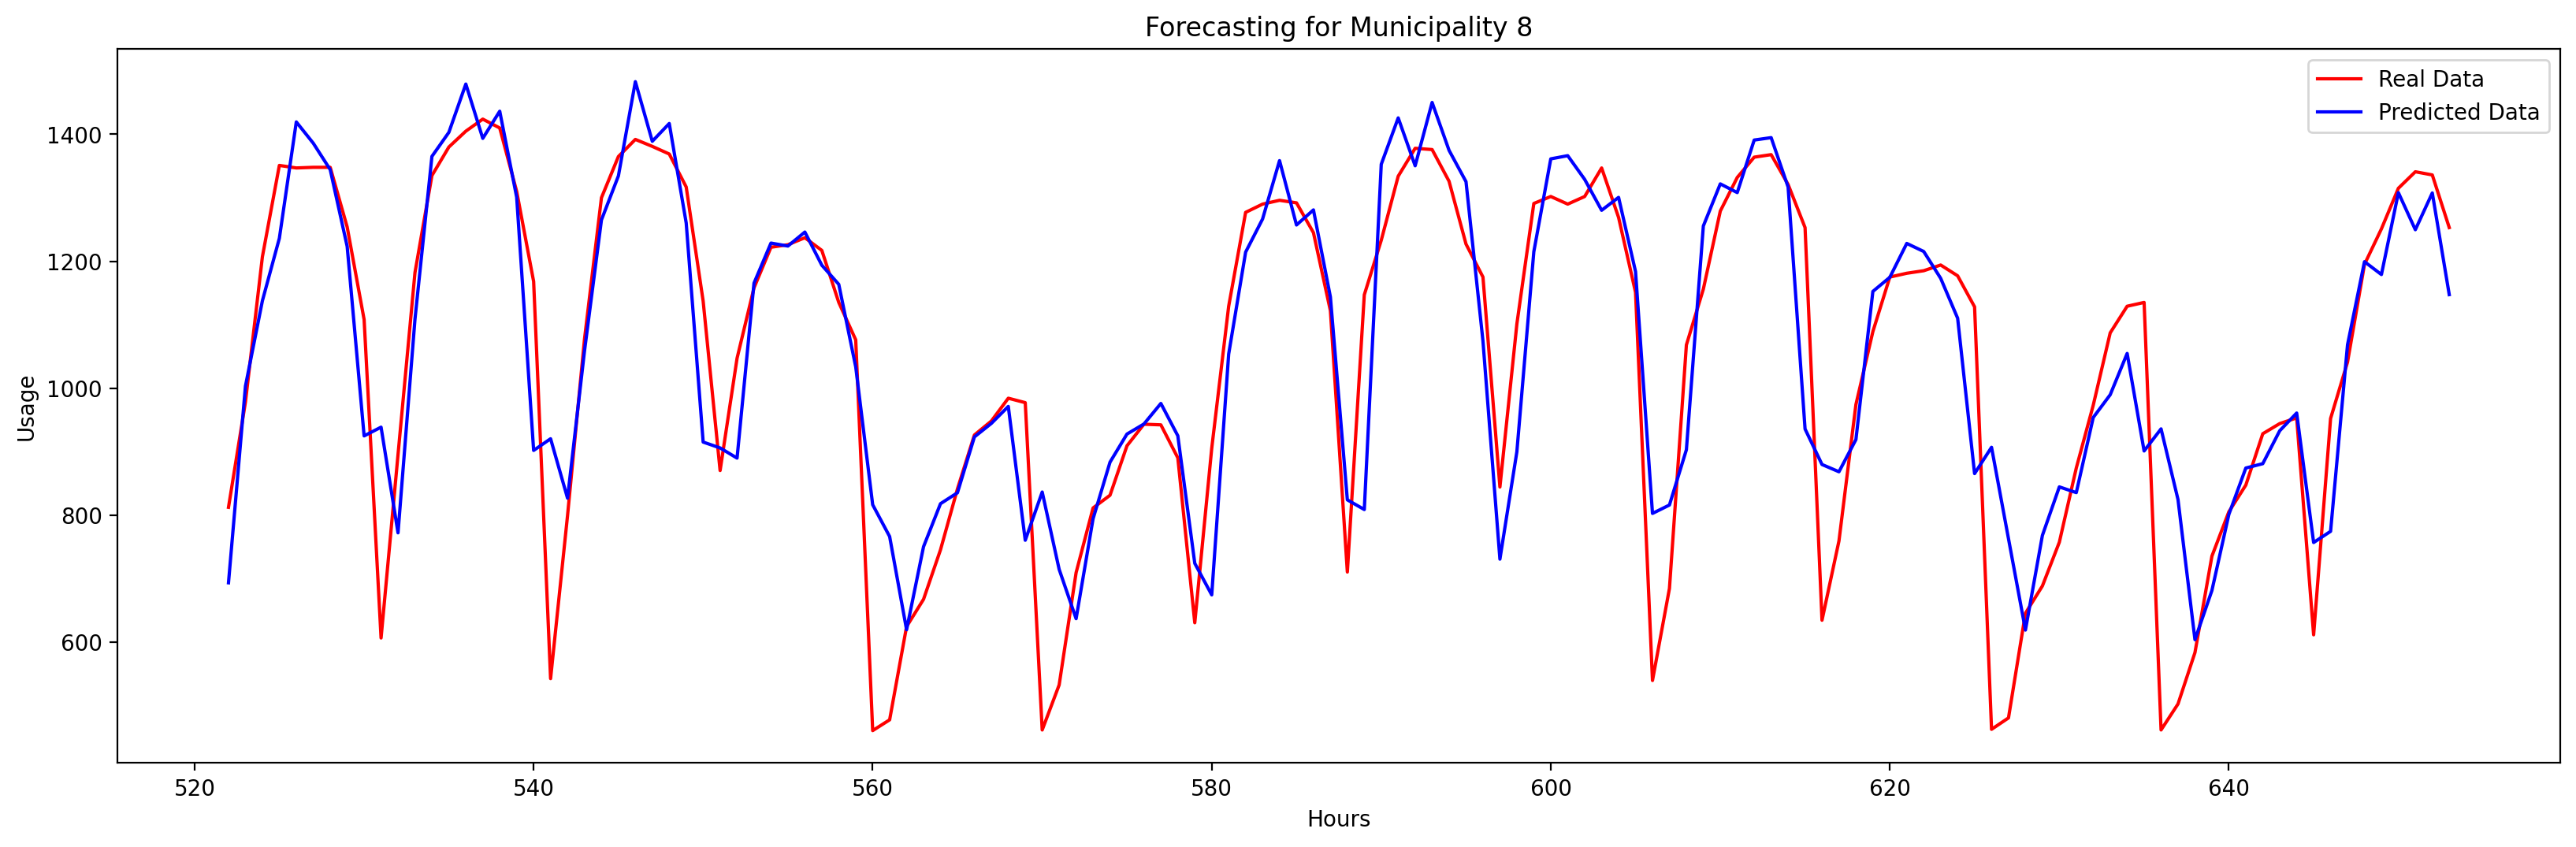

5/5 [==============================] - 0s 1ms/step
RMSE for Municipality 9: 82.6763


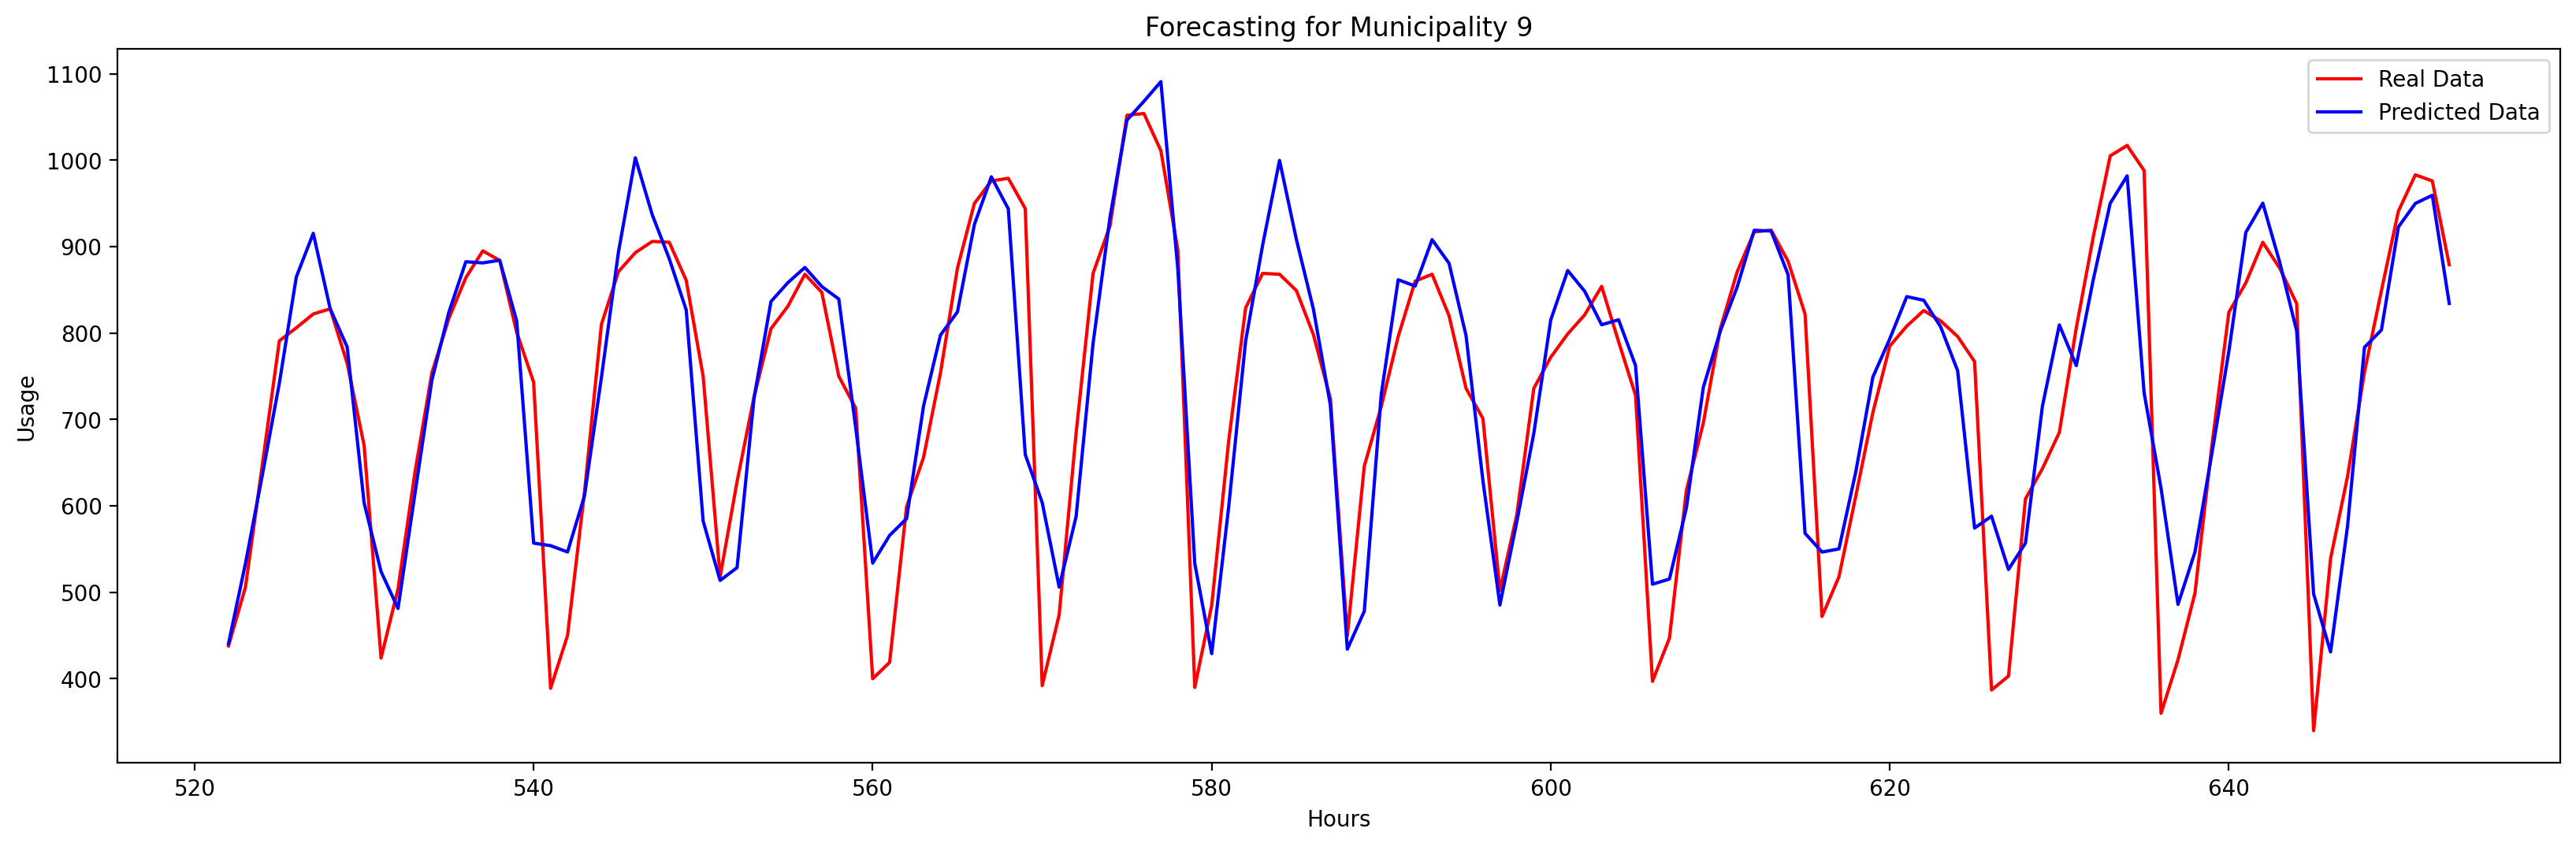

In [49]:
# Loop through each train and test dataset and fit the 1D CNN model, make predictions, and plot the results
for i in range(10):
    # Normalize the data
    scaler = MinMaxScaler()
    train_datasets[i][['Usage', 'Total_Capacity']] = scaler.fit_transform(train_datasets[i][['Usage', 'Total_Capacity']])
    test_datasets[i][['Usage', 'Total_Capacity']] = scaler.transform(test_datasets[i][['Usage', 'Total_Capacity']])
    
    # Prepare the input and output data
    X_train, y_train = create_dataset(train_datasets[i][['Usage', 'Total_Capacity']], train_datasets[i]['Usage'], time_steps)
    X_test, y_test = create_dataset(test_datasets[i][['Usage', 'Total_Capacity']], test_datasets[i]['Usage'], time_steps)

    # Build the 1D CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 2)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)

    # Rescale the predicted and actual usage data back to their original scale
    y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))]))[:, 0]
    y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros_like(y_pred)]))[:, 0]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    print(f"RMSE for Municipality {i}: {rmse:.4f}")

    # Plot the actual vs. predicted values
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_rescaled, 'r-', label='Real Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred)), y_pred_rescaled, 'b-', label='Predicted Data')
    plt.xlabel('Hours')
    plt.ylabel('Usage')
    plt.title(f'Forecasting for Municipality {i}')
    plt.legend(loc="best")
    plt.show()


Based on the provided RMSE scores for both the Exponential Smoothing and the CNN models, we can compare their performance for each municipality:

| Municipality | Exponential Smoothing RMSE | CNN RMSE |
|--------------|----------------------------|----------|
| 0            | 340.9772                   | 171.1170 |
| 1            | 120.5679                   | 46.9981  |
| 2            | 132.9360                   | 66.8967  |
| 3            | 402.2167                   | 154.1827 |
| 4            | 976.2654                   | 336.7585 |
| 5            | 123.4987                   | 39.3344  |
| 6            | 323.8531                   | 145.4946 |
| 7            | 320.4777                   | 136.7220 |
| 8            | 333.1266                   | 136.9544 |
| 9            | 208.3095                   | 82.6763  |

From the table above, it is clear that the CNN model outperforms the Exponential Smoothing model for all municipalities, as the RMSE values are lower for the CNN model across all cases. This indicates that the CNN model is more accurate in predicting the hourly maximum electricity usage for the given dataset